# Introduction
The purpose of this study is to enhance the accuracy of sunspot number (SN) prediction using advanced deep learning techniques for time series modeling. This research aims to address the challenges posed by the complex characteristics of SN data, non-Gaussian, and nonlinear nature.



## Table of Contents

- [Introduction](#introduction)
- [Sunspot Number Time Series Analysis and Forecasting](#sunspot-number-time-series-analysis-and-forecasting)
    - [Problem Definition](#problem-definition)
    - [Data Collection](#data-collection)
    - [Data Preprocessing](#data-preprocessing)
        - [Chronological Order and Equidistant Timestamps](#chronological-order-and-equidistant-timestamps)
        - [Scaling](#scaling)
        - [Initial Visualisation](#initial-visualisation)
    - [Feature Engineering](#feature-engineering)
        - [Time Features](#time-features)
    - [Data Splitting](#data-splitting)
    - [Time Series Data Analysis](#time-series-data-analysis)
        - [Gaussian or Non-Gaussian Distribution Analysis](#gaussian-or-non-gaussian-distribution-analysis)
            - [Histogram](#histogram)
            - [QQ Plot](#qq-plot)
            - [Shapiro-Wilk Test](#shapiro-wilk-test)
        - [Fourier Analysis (Lomb-Scargle Periodogram)](#fourier-analysis-lomb-scargle-periodogram)
        - [Autocorrelation Analysis (ACF/PACF)](#autocorrelation-analysis-acfpacf)
        - [Stationarity Tests (ADF/KPSS)](#stationarity-tests-adfkpss)
- [Models](#models)
    - [LSTM](#lstm)
    - [CNN-LSTM](#cnn-lstm)
    - [RNN](#rnn)
    - [GRU](#gru)
- [Time Series Forecasting](#time-series-forecasting)
- [Residual Data Analysis](#residual-data-analysis)
    - [Scale the Residual Data](#scale-the-residual-data)
    - [Create Sequences for Residual Data](#create-sequences-for-residual-data)
    - [Split the Data](#split-the-data)
    - [Gaussian or Non-Gaussian Distribution](#gaussian-or-non-gaussian-distribution)
    - [LSTM on Residual Data](#lstm-on-residual-data)
    - [CNN-LSTM on Residual Data](#cnn-lstm-on-residual-data)
    - [RNN Model on Residual Data](#rnn-model-on-residual-data)
    - [GRU Model on Residual Data](#gru-model-on-residual-data)
- [Explainable AI (XAI) Analysis](#explainable-ai-xai-analysis)
- [Window Size Optimization Based on XAI Insights](#window-size-optimization-based-on-xai-insights)
    - [Window Size 5](#window-size-5)
    - [Window Size 7](#window-size-7)
    - [Window Size 10](#window-size-10)
    - [Window Size vs. Model Performance](#window-size-vs-model-performance)
- [Conclusion](#conclusion)


<a id="problem-definition"></a>
## Problem Definition

**Goal:** To analyze the historical monthly sunspot number data (from 1749 to 2025) and develop time series models (including deep learning approaches like LSTM, CNN-LSTM, RNN) to forecast future sunspot activity for the next 11 years (132 months).




<a id="data-collection"></a>
## Data Collection

**Data Source:** The data used is the "Sunspot Index and Long-term Solar Observations" (SILSO) monthly total sunspot number dataset, version 2.0.
File: `SN_m_tot_V2.0.csv`

**Loading:** We load the data using pandas. The raw file format requires parsing specific columns.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
df= pd.read_csv(r"/content/drive/MyDrive/DL_Project/SN_m_tot_V2.0.csv",header=None)
df

0
0     1749;01;1749.042;  96.7; -1.0;   -1;1
1     1749;02;1749.123; 104.3; -1.0;   -1;1
2     1749;03;1749.204; 116.7; -1.0;   -1;1
3     1749;04;1749.288;  92.8; -1.0;   -1;1
4     1749;05;1749.371; 141.7; -1.0;   -1;1
...                                     ...
3308  2024;09;2024.706; 141.1; 19.5; 1047;1
3309  2024;10;2024.791; 166.4; 23.9;  893;0
3310  2024;11;2024.873; 152.5; 20.9;  681;0
3311  2024;12;2024.958; 154.5; 25.6;  572;0
3312  2025;01;2025.042; 137.0; 23.3;  670;0

[3313 rows x 1 columns]

<a id="data-preprocessing"></a>
## Data Preprocessing

Preparing the data for time series analysis involves several steps: ensuring correct data types, handling missing values, scaling, and potentially resampling.

In [ ]:
pd.to_datetime(df[0][3300][0:7].replace(";","-"))

Timestamp('2024-01-01 00:00:00')

<a id="chronological-order-and-equidistant-timestamps"></a>
### Chronological Order and Equidistant Timestamps

Convert the 'time' column to datetime objects and set it as the index. This ensures the data is chronologically ordered and allows for time-based indexing and resampling. The data appears to be already monthly, which provides equidistant timestamps.

In [ ]:
ssn_m = []
time = []

for i in df[0]:
  ssn_m.append(float(i[18:23]))
  time.append(i[0:7].replace(";","-"))


In [ ]:
df_m = pd.DataFrame()
df_m["time"] = time
df_m["ssn_m"] = ssn_m

In [ ]:
df_m["time"][132]

'1760-01'

In [ ]:
df_m

time  ssn_m
0     1749-01   96.7
1     1749-02  104.3
2     1749-03  116.7
3     1749-04   92.8
4     1749-05  141.7
...       ...    ...
3308  2024-09  141.1
3309  2024-10  166.4
3310  2024-11  152.5
3311  2024-12  154.5
3312  2025-01  137.0

[3313 rows x 2 columns]

<a id="scaling"></a>
### Scaling

Neural networks often perform better with scaled input data, typically between 0 and 1 or -1 and 1. We use `MinMaxScaler` to scale the 'ssn_m' column.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler =MinMaxScaler()
df_m["scaled_ssn"]  = scaler.fit_transform(df_m[['ssn_m']])
df_m

time  ssn_m  scaled_ssn
0     1749-01   96.7    0.242843
1     1749-02  104.3    0.261929
2     1749-03  116.7    0.293069
3     1749-04   92.8    0.233049
4     1749-05  141.7    0.355851
...       ...    ...         ...
3308  2024-09  141.1    0.354345
3309  2024-10  166.4    0.417880
3310  2024-11  152.5    0.382973
3311  2024-12  154.5    0.387996
3312  2025-01  137.0    0.344048

[3313 rows x 3 columns]

<a id="initial-visualisation"></a>
### Initial Visulisation

Visually inspect the time series plot to get an initial idea about trends and seasonality, which relate to stationarity. A stationary series has constant mean, variance, and autocorrelation over time.

In [ ]:
fig = px.line(df_m,x="time",y="ssn_m",labels={'time':"Time",'ssn_m':"Sunpot Numbers"},title="Monthly Sunspot NUmbers")
fig.show()

<a id="feature-engineering"></a>
## Feature Engineering

Create features that might help the model learn the underlying patterns.

In [ ]:
def create_sequence(data,seq_length):
  x=[]
  y=[]
  for i in range(len(data)-seq_length):
    x.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
  return np.array(x),np.array(y)

<a id="time-features"></a>
### Time Features

Extract features like month or year. These might capture seasonality or long-term trends not handled by decomposition or lag features alone. (Optional for this dataset as the 11-year cycle is dominant).

In [ ]:
data = df_m["scaled_ssn"]
seq_length = 132
x,y = create_sequence(data,seq_length)
x.shape , y.shape

((3181, 132), (3181,))

In [ ]:
df_m

time  ssn_m  scaled_ssn
0     1749-01   96.7    0.242843
1     1749-02  104.3    0.261929
2     1749-03  116.7    0.293069
3     1749-04   92.8    0.233049
4     1749-05  141.7    0.355851
...       ...    ...         ...
3308  2024-09  141.1    0.354345
3309  2024-10  166.4    0.417880
3310  2024-11  152.5    0.382973
3311  2024-12  154.5    0.387996
3312  2025-01  137.0    0.344048

[3313 rows x 3 columns]

In [ ]:
dft = pd.DataFrame(x)
dft.head()

0         1         2         3         4         5         6    \
0  0.242843  0.261929  0.293069  0.233049  0.355851  0.349573  0.396786   
1  0.261929  0.293069  0.233049  0.355851  0.349573  0.396786  0.277499   
2  0.293069  0.233049  0.355851  0.349573  0.396786  0.277499  0.317680   
3  0.233049  0.355851  0.349573  0.396786  0.277499  0.317680  0.315922   
4  0.355851  0.349573  0.396786  0.277499  0.317680  0.315922  0.663737   

        7         8         9    ...       122       123       124       125  \
0  0.277499  0.317680  0.315922  ...  0.195881  0.196635  0.205173  0.209191   
1  0.317680  0.315922  0.663737  ...  0.196635  0.205173  0.209191  0.213461   
2  0.315922  0.663737  0.356605  ...  0.205173  0.209191  0.213461  0.298343   
3  0.663737  0.356605  0.306881  ...  0.209191  0.213461  0.298343  0.323204   
4  0.356605  0.306881  0.317680  ...  0.213461  0.298343  0.323204  0.249874   

        126       127       128       129       130       131  
0  0.213461  0.298343  0.323204  0.249874  0.193872  0.238574  
1  0.298343  0.323204  0.249874  0.193872  0.238574  0.281768  
2  0.323204  0.249874  0.193872  0.238574  0.281768  0.249121  
3  0.249874  0.193872  0.238574  0.281768  0.249121  0.312657  
4  0.193872  0.238574  0.281768  0.249121  0.312657  0.244098  

[5 rows x 132 columns]

<a id="data-splitting"></a>
## Data Splitting

### Train-Test Split

To evaluate the performance of our time series models, we need to split the data into training and testing sets. Here's how we'll approach this:

- **Chronological Split:** Since time series data has an inherent order, we'll use a chronological split where the training set contains earlier data points, and the test set contains the most recent data points. This simulates how the model would perform in real-world forecasting scenarios.

- **Split Ratio:** We'll use an 80-20 split, where 80% of the data is used for training and 20% for testing. This ratio is common in time series analysis to ensure enough data for training while still having a substantial amount for validation.

- **Sequence Length:** Given our sequence length of 132 (representing 11 years of monthly data), we'll ensure that the split point does not break any sequences.

Here's the code to perform the split:



In [ ]:
x_train = x[:int(0.8*len(x))]
x_test = x[int(0.8*len(x)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2544, 132)
(637, 132)
(2544,)
(637,)


In [ ]:
# Create a new DataFrame for visualization
plot_df = df_m.copy()

# Add split labels (train = 0, test = 1)
plot_df['split'] = 0  # Initialize all as training
plot_df.loc[len(x_train)+seq_length:, 'split'] = 1  # Mark test portion

# Create the plot
fig = px.line(plot_df, x='time', y='scaled_ssn', color='split',
              color_discrete_sequence=['blue', 'red'],
              labels={'time': 'Time', 'scaled_ssn': 'Scaled Sunspot Number'},
              title='Sunspot Numbers with Train/Test Split')

# Customize hover data
fig.update_traces(hovertemplate='<br>'.join([
    'Date: %{x}',
    'Scaled SSN: %{y:.2f}',
    '<extra></extra>'
]))

# Add split line annotation
split_date = plot_df['time'][len(x_train)+seq_length]
fig.add_vline(x=split_date, line_width=2, line_dash='dash', line_color='green')
fig.add_annotation(x=split_date, y=1.05, text="Train/Test Split",
                   showarrow=False, font=dict(color='green'))

fig.show()


---

<a id="time-series-data-analysis"></a>
# Time series Data Analysis

Visualize and analyze the data to understand its characteristics.

<a id="gaussian-or-non-gaussian-distribution-analysis"></a>
## Gaussian or Non-Gaussian Distribution Analysis

Understanding the distribution of sunspot numbers is crucial for selecting appropriate statistical models and transformations. Here, we'll analyze whether the sunspot data follows a Gaussian (normal) distribution or not.


<a id="histogram"></a>
### Histogram

A histogram provides a visual representation of the data distribution:


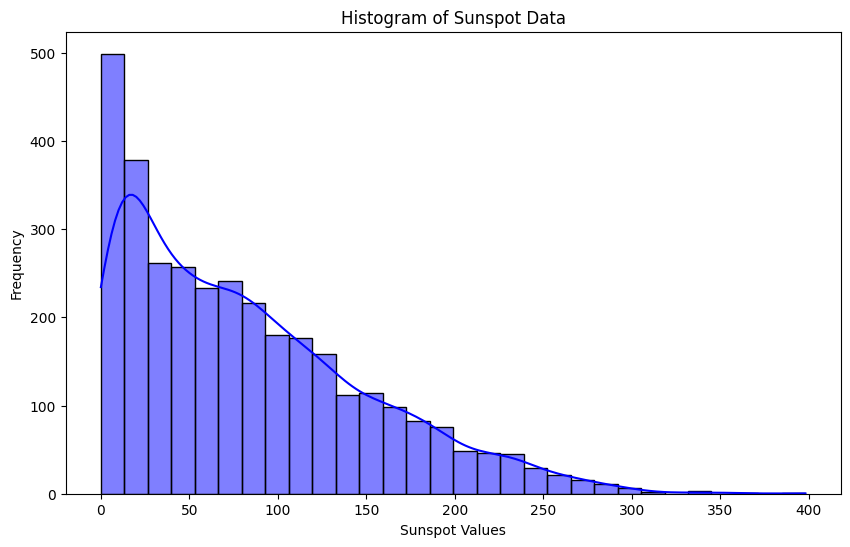

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the scaled sunspot data for visualization
flattened_data = df_m["ssn_m"].values.flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(flattened_data, kde=True, bins=30, color='blue')
plt.title('Histogram of Sunspot Data')
plt.xlabel('Sunspot Values')
plt.ylabel('Frequency')
plt.show()


<a id="qq-plot"></a>
### QQ Plot

A Quantile-Quantile (QQ) plot compares the quantiles of the data against the quantiles of a normal distribution:



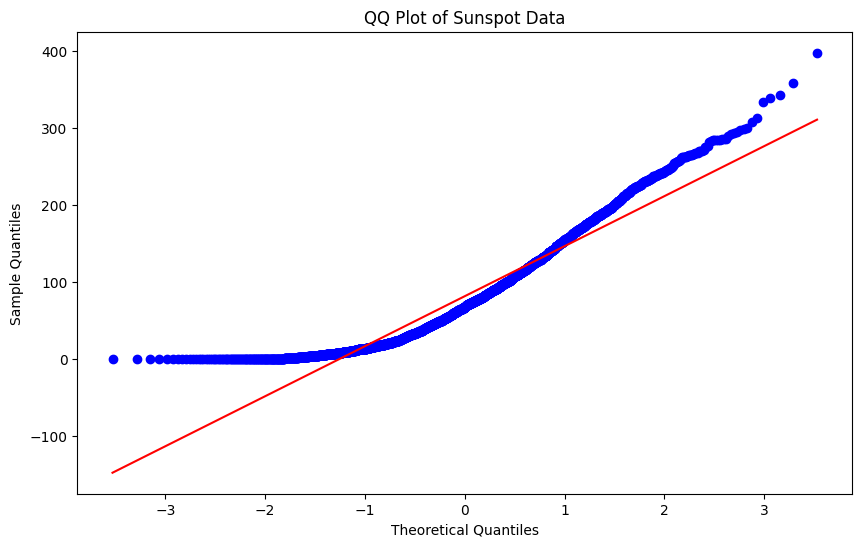

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Generate QQ plot
plt.figure(figsize=(10, 6))
stats.probplot(flattened_data, dist="norm", plot=plt)
plt.title("QQ Plot of Sunspot Data")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()


<a id="shapiro-wilk-test"></a>
### Shapiro-Wilk Test

The Shapiro-Wilk test is a formal statistical test for normality:



In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Assuming df_m is your DataFrame with 'ssn_m' column
actual_sunspot_values = df_m['ssn_m'].values

# Perform Shapiro-Wilk test
statistic, p_value = stats.shapiro(actual_sunspot_values)

print(f"Shapiro-Wilk Test Statistic: {statistic}")
print(f"P-Value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value > alpha:
    print("The sunspot data is likely normally distributed (Fail to Reject H0), because p-value > 0.05.")
else:
    print("The sunspot data is likely not normally distributed (Reject H0).")

Shapiro-Wilk Test Statistic: 0.9192636938514596
P-Value: 6.502654643652253e-39
The sunspot data is likely not normally distributed (Reject H0).


<a id="fourier-analysis-lomb-scargle-periodogram"></a>
### Fourier Analysis (Lomb-Scargle Periodogram)

Identify dominant frequencies (periods) in the data, especially useful for unevenly spaced data or confirming cyclical patterns.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

d =pd.read_csv(r"/content/drive/MyDrive/DL_Project/SN_m_tot_V2.0.csv")

ssn= [96.7]
year=[1749]
month = [1]

for i in range(len(d)):
    ssn.append(float(d['1749;01;1749.042;  96.7; -1.0;   -1;1'][i][18:23]))
    year.append(str(d['1749;01;1749.042;  96.7; -1.0;   -1;1'][i][:4]))
    month.append(int(d['1749;01;1749.042;  96.7; -1.0;   -1;1'][i][5:7]))

df = pd.DataFrame()
df["ssn"] = ssn
df["year"]=year

df["month"]=month

date = []
for i in range(len(df)):
    date.append(str(df["year"][i]) + "-" +str(df["month"][i]))
df["date"] = date
df["date"] = pd.to_datetime(df["date"])

seconds = []
for i in range(len(d)+1):
    j=i+1
    seconds.append(j*30*24*60*60)
df["seconds"] = seconds

t=df['seconds']
y=df['ssn']

import numpy as np

# Make times manageable (Scargle periodogram is time-shift invariant)
time = t - t[0]
n0=len(time)
#fmin=1.0/np.max(time)
fmax = n0 / (2.0 * np.max(time))#nyquist rate
#print(fmax)

# Assuming 't' is your time array and 'signal' is your data array
# Use a 11-point, order 0, and second degree Savitzky-Golay Filter
y=list(df['ssn'])
from scipy.signal import savgol_filter
window_size = 95
order = 2
sy = savgol_filter(y, window_size, order)
#stime=savgol_filter(t, window_size, order)
# Now, 'savgol_filtered_signal' contains the Savitzky-Golay filtered version of your data
fy=y-sy #residual
df

ssn  year  month       date     seconds
0      96.7  1749      1 1749-01-01     2592000
1     104.3  1749      2 1749-02-01     5184000
2     116.7  1749      3 1749-03-01     7776000
3      92.8  1749      4 1749-04-01    10368000
4     141.7  1749      5 1749-05-01    12960000
...     ...   ...    ...        ...         ...
3308  141.1  2024      9 2024-09-01  8576928000
3309  166.4  2024     10 2024-10-01  8579520000
3310  152.5  2024     11 2024-11-01  8582112000
3311  154.5  2024     12 2024-12-01  8584704000
3312  137.0  2025      1 2025-01-01  8587296000

[3313 rows x 5 columns]

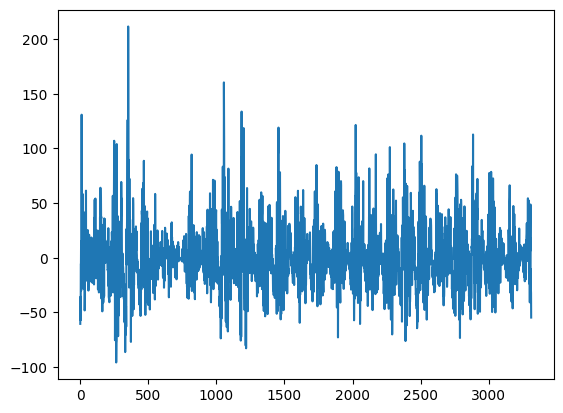

In [ ]:
plt.plot(fy)

/usr/local/lib/python3.11/dist-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning:

divide by zero encountered in divide



(0.0, 2e-05)

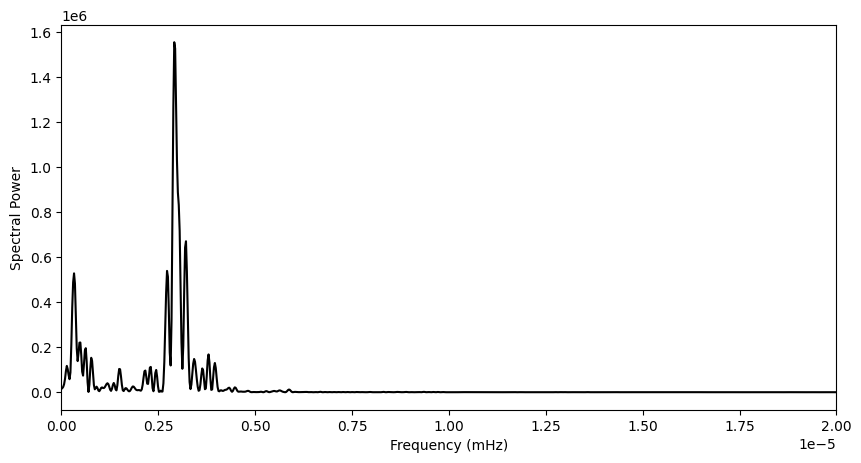

In [ ]:
y=list(y)
ls=LombScargle(t, sy)
freq1, p_ls1 = ls.autopower(minimum_frequency=0,maximum_frequency=fmax,normalization='psd')
fig, ax = plt.subplots(1, figsize=(10, 5), sharex=True)
ax.plot(freq1*1000, p_ls1, '-k', label='Lomb-Scargle Periodogram')
ax.set(ylabel='Spectral Power')
ax.set(xlabel='Frequency (mHz)')
ax.set_xlim(0,0.00002)

dominant period of residual_data :


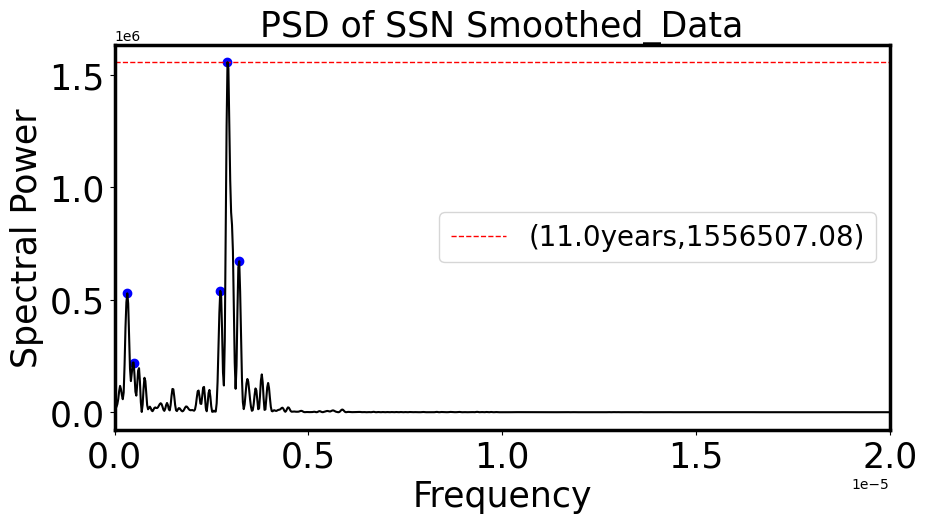

In [ ]:
from scipy.signal import find_peaks
y = p_ls1
peaks_indices = find_peaks(y)[0]
peaks_indices
l = []
for i in peaks_indices:
    l.append(p_ls1[i])
l.sort()

top_power=l[len(l)-5:len(l)]


k=list(p_ls1)
top_index=[]
for i in top_power:
    top_index.append(k.index(i))
dominant_periods = []
for i in top_index:
    dominant_periods.append( ((1/freq1[i])/(2592000)/12) )


dominant_periods

top_freq = []
for i in top_index:
    top_freq.append(freq1[i])

top_power = np.array(top_power)
top_freq = np.array(top_freq)
print("dominant period of residual_data :")
dominant_periods


m=np.round(((1/top_freq[-1])/(2592000)/12))
n=np.round(top_power[-1],2)
fig, ax = plt.subplots(1, figsize=(10, 5), sharex=True)
plt.axhline(y=n, color='red', linestyle='--', linewidth=1)
plt.axvline(x=m, color='red', linestyle='--', linewidth=1)
ax.scatter(top_freq*1000,top_power,c="b")
ax.plot(freq1*1000, p_ls1, '-k', label='Lomb-Scargle Periodogram',)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.5)

plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.title('PSD of SSN Smoothed_Data',size =25)
# plt.text(top_freq[0]*1000,1400000 ,"(a)" ,fontdict={'family': 'Times New Roman', 'color': 'black', 'size': 30})
plt.xlabel('Frequency' , size=25)
plt.ylabel('Spectral Power',size =25)
ax.set_xlim(0,0.00002)

plt.legend([f"({m}years,{n})"],fontsize = 20)
plt.show()

<a id="autocorrelation-analysis-acfpacf"></a>
### Autocorrelation Analysis (ACF/PACF)

Analyze the correlation of the time series with lagged versions of itself.
- ACF (Autocorrelation Function): Shows correlation with lags. Helps identify seasonality.
- PACF (Partial Autocorrelation Function): Shows correlation with lags after removing effects of intervening lags.

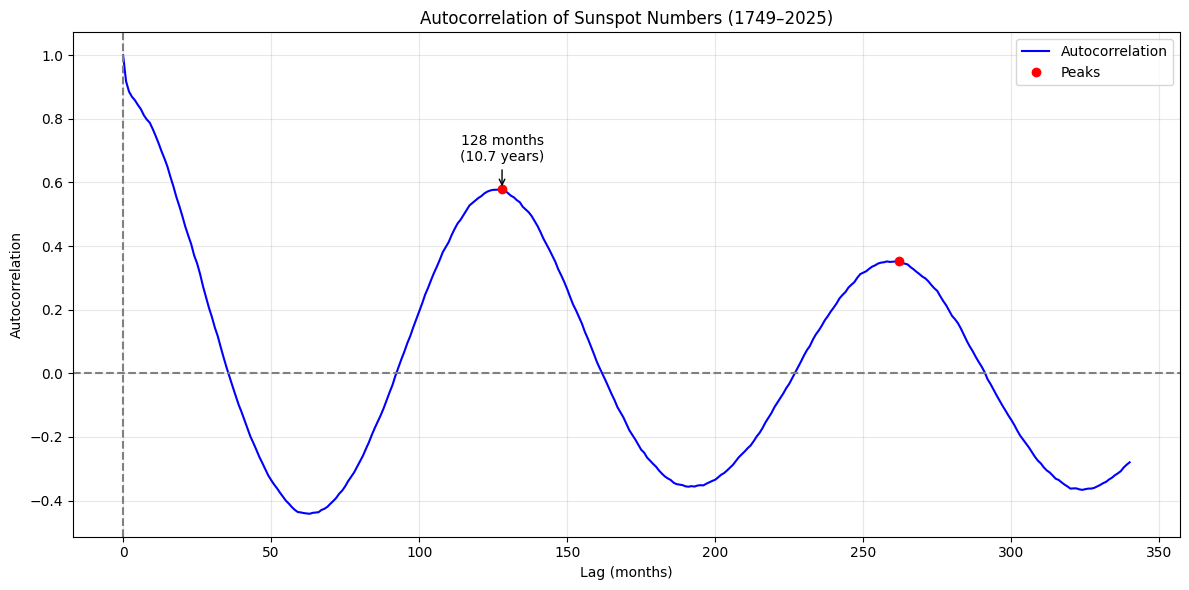

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import scipy.signal as signal

# Calculate autocorrelation with maximum lag of 20 years (340 months)
def detect_sunspot_periodicity(data, max_lag=340):
    # Calculate autocorrelation function
    acf_values = acf(data, nlags=max_lag, fft=True)
    lags = np.arange(len(acf_values))

    # Find peaks in autocorrelation
    peaks, _ = signal.find_peaks(acf_values, height=0.2, distance=30)

    return lags, acf_values, peaks

# Convert time to datetime index if not already
# df_m['time'] = pd.to_datetime(df_m['time'])
# df_m.set_index('time', inplace=True)

# Apply to sunspot data
lags, acf_values, peaks = detect_sunspot_periodicity(df_m['ssn_m'])

# Plot autocorrelation with peaks
plt.figure(figsize=(12, 6))
plt.plot(lags, acf_values, 'b-', label='Autocorrelation')
plt.plot(lags[peaks], acf_values[peaks], 'ro', label='Peaks')

# Add reference lines
plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=0, color='gray', linestyle='--')

# Annotate the first peak (ignoring lag=0)
if len(peaks) > 0:
    first_peak = peaks[0]
    months = lags[first_peak]
    plt.annotate(f'{months} months\n({months/12:.1f} years)',
                 xy=(months, acf_values[first_peak]),
                 xytext=(0, 20),
                 textcoords='offset points',
                 ha='center',
                 arrowprops=dict(arrowstyle='->'))

plt.title('Autocorrelation of Sunspot Numbers (1749–2025)')
plt.xlabel('Lag (months)')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()




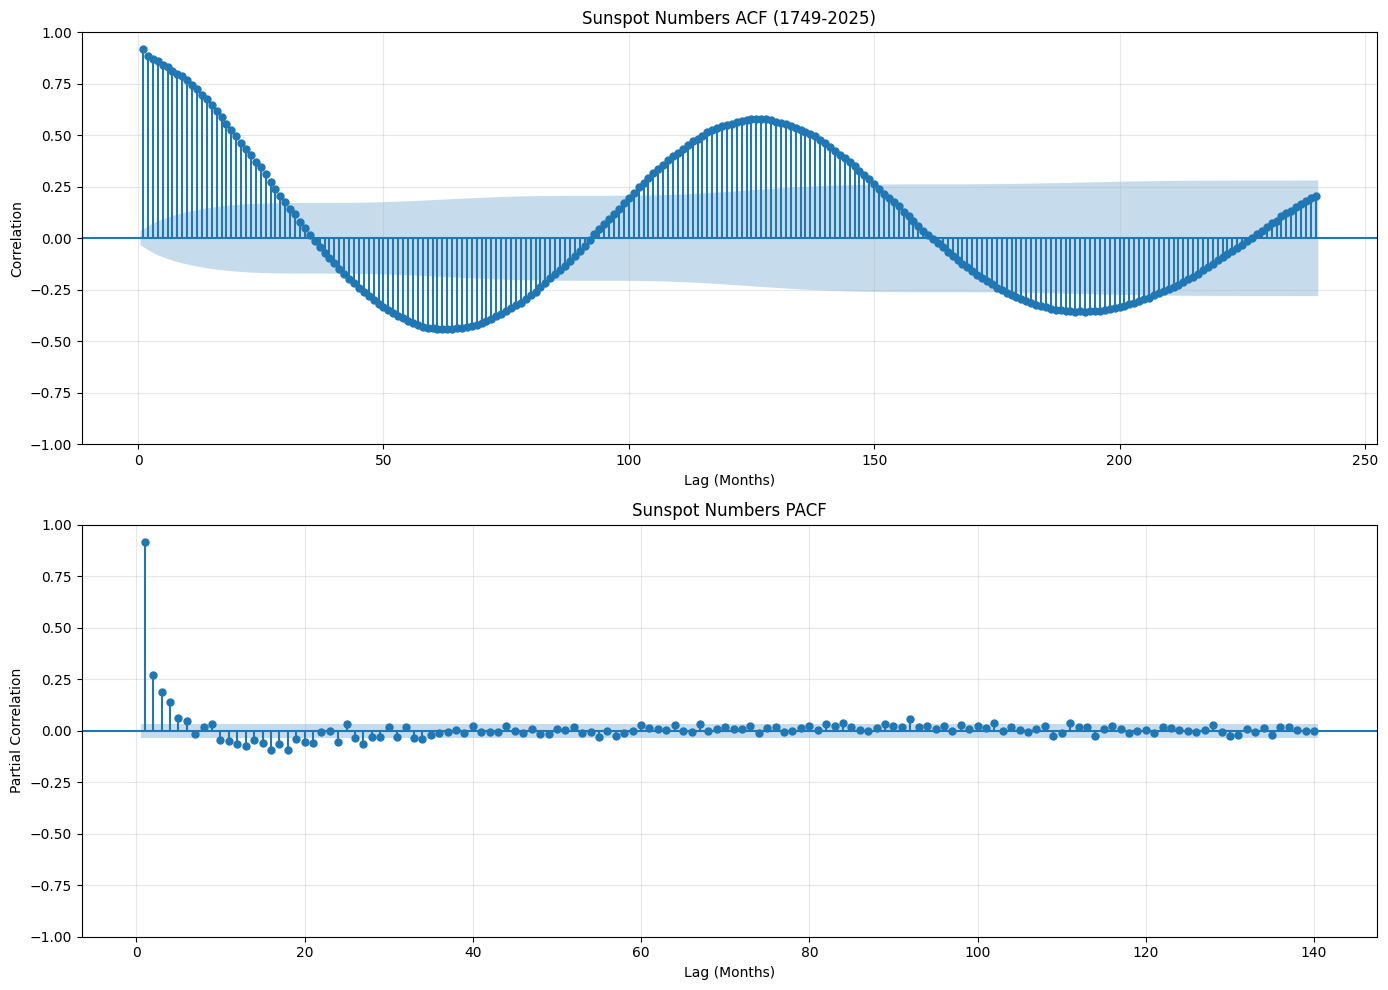

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create combined ACF/PACF plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# ACF Plot (Focus on 20-year period)
plot_acf(df_m['ssn_m'],
         lags=240,  # 20 years (240 months)
         alpha=0.05,  # 95% confidence interval
         title='Sunspot Numbers ACF (1749-2025)',
         ax=ax1,
         zero=False)
ax1.set_xlabel('Lag (Months)')
ax1.set_ylabel('Correlation')
ax1.grid(True, alpha=0.3)

# PACF Plot (First 5 years for AR order identification)
plot_pacf(df_m['ssn_m'],
          lags=140,  # 20 years (240 months)
          alpha=0.05,
          title='Sunspot Numbers PACF',
          ax=ax2,
          zero=False)
ax2.set_xlabel('Lag (Months)')
ax2.set_ylabel('Partial Correlation')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Direct approach to find the  cycle
acf_values = acf(df_m['ssn_m'], nlags=240, fft=True)  # Calculate for 20 years

# Find the most prominent peak after lag 60 (5 years)
cycle_region = acf_values[60:180]  # Look between 5-15 years
max_corr_idx = np.argmax(cycle_region) + 60  # Add offset back

print(f"Strongest autocorrelation at lag: {max_corr_idx} months ({max_corr_idx/12:.2f} years)")
print(f"Autocorrelation value: {acf_values[max_corr_idx]:.4f}")


Strongest autocorrelation at lag: 128 months (10.67 years)
Autocorrelation value: 0.5792


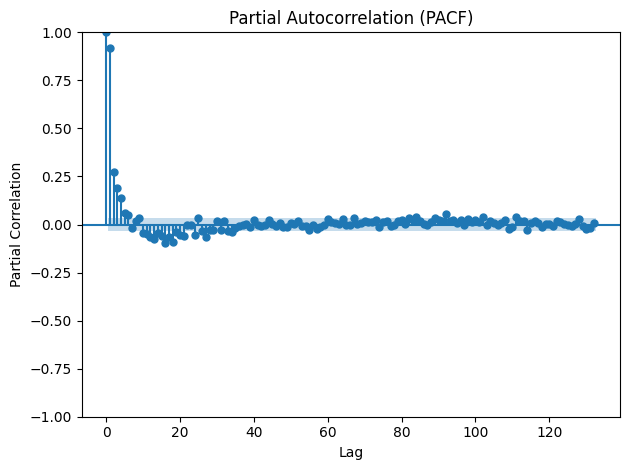

⚠️ No significant lags found. Suggesting window size = 1 (weak autocorrelation)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

def suggest_window_size(residuals, max_lag=132, alpha=0.05, method='ywm'):
    # Drop NA values
    residuals = residuals.dropna()

    # Get PACF values and confidence interval
    pacf_vals, confint = pacf(residuals, nlags=max_lag, alpha=alpha, method=method)

    # Find significant lags (where pacf value is outside confidence interval)
    significant_lags = []
    for lag in range(1, len(pacf_vals)):  # skip lag 0
        lower = confint[lag][0]
        upper = confint[lag][1]
        if pacf_vals[lag] < lower or pacf_vals[lag] > upper:
            significant_lags.append(lag)

    # Plot PACF
    plot_pacf(residuals, lags=max_lag, alpha=alpha, method=method)
    plt.title("Partial Autocorrelation (PACF)")
    plt.xlabel("Lag")
    plt.ylabel("Partial Correlation")
    plt.tight_layout()
    plt.show()

    # Suggest window size
    if significant_lags:
        suggested = max(significant_lags)
        print(f"✅ Suggested window size: {suggested} (based on PACF)")
    else:
        suggested = 1
        print("⚠️ No significant lags found. Suggesting window size = 1 (weak autocorrelation)")

    return suggested

# Example usage:
# Assuming df_m['ssn_m'] contains your residuals from seasonal decomposition
window_size = suggest_window_size(df_m['ssn_m'])


<a id="stationarity-tests-adfkpss"></a>
### Stationarity Tests (ADF/KPSS)

Augmented Dickey-Fuller Test

Formally test for stationarity using statistical tests.
- **Augmented Dickey-Fuller (ADF) Test:**
    - Null Hypothesis (H0): The series has a unit root (is non-stationary).
    - Alternative Hypothesis (H1): The series is stationary.
    - *Interpretation:* If p-value < 0.05, reject H0 -> Series is likely stationary.

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss

# Custom function for ADF test
def adf_test(timeseries):
    print("=== Augmented Dickey-Fuller Test ===")
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] < 0.05:
        print("Strong evidence against null hypothesis")
        print("Conclusion: Series is STATIONARY")
    else:
        print("Weak evidence against null hypothesis")
        print("Conclusion: Series is NON-STATIONARY")
# Example: Check stationarity of the raw sunspot-like data
adf_test(df_m['ssn_m'])

=== Augmented Dickey-Fuller Test ===
ADF Statistic: -10.6160
p-value: 0.0000
Critical Values:
	1%: -3.4323
	5%: -2.8624
	10%: -2.5672
Strong evidence against null hypothesis
Conclusion: Series is STATIONARY


KPSS Test

- **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:**
    - Null Hypothesis (H0): The series is stationary around a deterministic trend.
    - Alternative Hypothesis (H1): The series has a unit root (is non-stationary).
    - *Interpretation:* If p-value < 0.05, reject H0 -> Series is likely non-stationary.

In [ ]:
# Custom function for KPSS test
def kpss_test(timeseries):
    print("\n=== KPSS Test ===")
    result = kpss(timeseries, regression='c', nlags='auto')
    print(f'KPSS Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] < 0.05:
        print("Strong evidence against null hypothesis")
        print("Conclusion: Series is NON-STATIONARY")
    else:
        print("Weak evidence against null hypothesis")
        print("Conclusion: Series is STATIONARY")
kpss_test(df_m['ssn_m'])


=== KPSS Test ===
KPSS Statistic: 0.1082
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Weak evidence against null hypothesis
Conclusion: Series is STATIONARY


<ipython-input-37-06d8b94ce87e>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




---

<a id="models"></a>
# Models

We will implement and evaluate several time series models.

**Evaluation Metrics:**
- RMSE (Root Mean Squared Error): sqrt(mean((actual - predicted)^2)) - Penalizes large errors more. Lower is better.
- MAE (Mean Absolute Error): mean(|actual - predicted|) - Average absolute difference. Lower is better.
- R² Score (Coefficient of Determination): Measures the proportion of variance explained by the model. Closer to 1 is better.


**Helper Functions for Denormalization and Evaluation:**

In [ ]:
def minmaxNorm(originalData):
    max2norm=max(originalData)
    min2norm=min(originalData)
    lenOriginal=len(originalData)
    normalizedData=np.zeros(lenOriginal)
    normalizedData = []
    for i in range (lenOriginal):
        normalizedData.append((originalData[i]-min2norm)/(max2norm-min2norm))
    return np.array(normalizedData)
def minmaxDeNorm( originalData, forecastedData):
    max2norm=max(originalData)
    min2norm=min(originalData)
    lenOriginal=len(forecastedData)
    denormalizedData=[]
    for i in range (lenOriginal):
        denormalizedData.append((forecastedData[i]*(max2norm-min2norm))+min2norm)
    return np.array(denormalizedData)

<a id="lstm"></a>
###LSTM

Long Short-Term Memory networks, suitable for learning long-range dependencies in sequential data.


In [ ]:
def create_supervised_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_supervised_data(df_m["scaled_ssn"], window_size=132)
# X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
pd.DataFrame(X)

0         1         2         3         4         5         6    \
0     0.242843  0.261929  0.293069  0.233049  0.355851  0.349573  0.396786   
1     0.261929  0.293069  0.233049  0.355851  0.349573  0.396786  0.277499   
2     0.293069  0.233049  0.355851  0.349573  0.396786  0.277499  0.317680   
3     0.233049  0.355851  0.349573  0.396786  0.277499  0.317680  0.315922   
4     0.355851  0.349573  0.396786  0.277499  0.317680  0.315922  0.663737   
...        ...       ...       ...       ...       ...       ...       ...   
3176  0.136866  0.287293  0.286037  0.311904  0.293822  0.366901  0.323204   
3177  0.287293  0.286037  0.311904  0.293822  0.366901  0.323204  0.282521   
3178  0.286037  0.311904  0.293822  0.366901  0.323204  0.282521  0.282521   
3179  0.311904  0.293822  0.366901  0.323204  0.282521  0.282521  0.258413   
3180  0.293822  0.366901  0.323204  0.282521  0.282521  0.258413  0.251632   

           7         8         9    ...       122       123       124  \
0     0.277499  0.317680  0.315922  ...  0.195881  0.196635  0.205173   
1     0.317680  0.315922  0.663737  ...  0.196635  0.205173  0.209191   
2     0.315922  0.663737  0.356605  ...  0.205173  0.209191  0.213461   
3     0.663737  0.356605  0.306881  ...  0.209191  0.213461  0.298343   
4     0.356605  0.306881  0.317680  ...  0.213461  0.298343  0.323204   
...        ...       ...       ...  ...       ...       ...       ...   
3176  0.282521  0.282521  0.258413  ...  0.268960  0.285033  0.316424   
3177  0.282521  0.258413  0.251632  ...  0.285033  0.316424  0.308890   
3178  0.258413  0.251632  0.268458  ...  0.316424  0.308890  0.260422   
3179  0.251632  0.268458  0.326469  ...  0.308890  0.260422  0.344048   
3180  0.268458  0.326469  0.226017  ...  0.260422  0.344048  0.432195   

           125       126       127       128       129       130       131  
0     0.209191  0.213461  0.298343  0.323204  0.249874  0.193872  0.238574  
1     0.213461  0.298343  0.323204  0.249874  0.193872  0.238574  0.281768  
2     0.298343  0.323204  0.249874  0.193872  0.238574  0.281768  0.249121  
3     0.323204  0.249874  0.193872  0.238574  0.281768  0.249121  0.312657  
4     0.249874  0.193872  0.238574  0.281768  0.249121  0.312657  0.244098  
...        ...       ...       ...       ...       ...       ...       ...  
3176  0.308890  0.260422  0.344048  0.432195  0.412104  0.494224  0.542441  
3177  0.260422  0.344048  0.432195  0.412104  0.494224  0.542441  0.354345  
3178  0.344048  0.432195  0.412104  0.494224  0.542441  0.354345  0.417880  
3179  0.432195  0.412104  0.494224  0.542441  0.354345  0.417880  0.382973  
3180  0.412104  0.494224  0.542441  0.354345  0.417880  0.382973  0.387996  

[3181 rows x 132 columns]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense
# Define the LSTM model
def build_lstm_model(sequence_length, n_features):
    model = Sequential([
        Input(shape=(sequence_length, n_features)),  # ✅ No warning
        LSTM(256, activation='relu', return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.0280 - val_loss: 0.0070
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0046 - val_loss: 0.0063
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/st

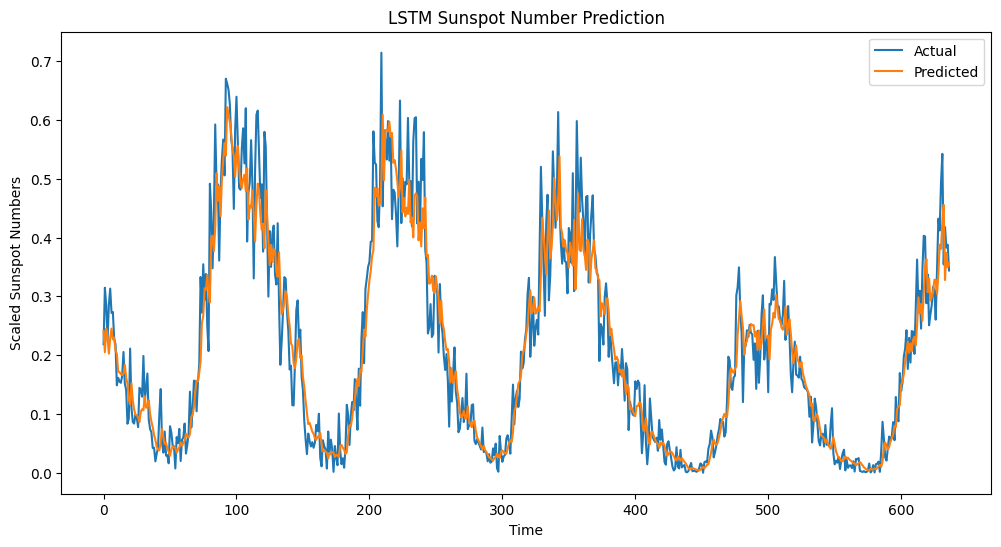

In [ ]:

# Set parameters
sequence_length = 132
n_features = 1
epochs = 100
batch_size = 32

# Reshape the input data for LSTM (samples, time steps, features)



# Build and train the model
model_lstm = build_lstm_model(sequence_length, n_features)
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model_lstm.predict(X_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Sunspot Number Prediction')
plt.xlabel('Time')
plt.ylabel('Scaled Sunspot Numbers')
plt.legend()
plt.show()



20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 22.275


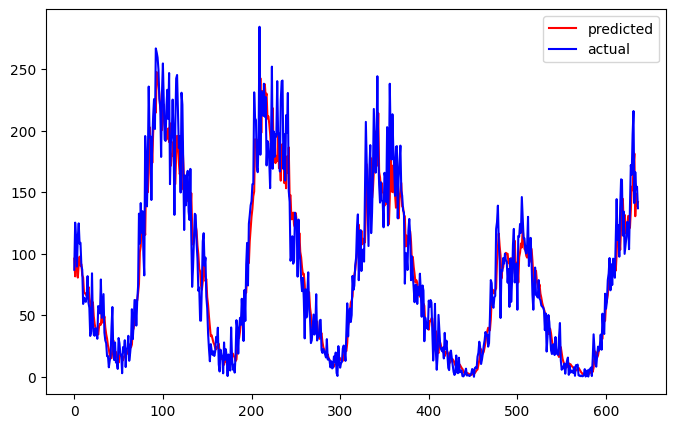

In [ ]:

originalData=np.array(df_m["ssn_m"])
predictions = model_lstm.predict(X_test)
predictions_rescaled = minmaxDeNorm( originalData, predictions)
len(predictions_rescaled),len(y_test)
y_test_rescaled = minmaxDeNorm(originalData, y_test)
plt.figure(figsize=(8,5))
plt.plot(predictions_rescaled,c="r")
plt.plot(y_test_rescaled,c="b")
plt.legend(["predicted","actual"])

from sklearn.metrics import mean_squared_error
import numpy as np

# Example: assume y_true and y_pred are your actual and predicted values
# y_true = df['actual_ssn']
# y_pred = df['predicted_ssn']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"RMSE: {rmse:.3f}")

In [ ]:
# Save the trained model in Keras format
model.save('sunspot_lstm_model.keras')

<a id="cnn-lstm"></a>
### CNN-LSTM

Combines Convolutional Neural Networks (to extract spatial features from the sequence) with LSTMs (to capture temporal dependencies).


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0270 - val_loss: 0.0066
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - val_loss: 0.0056
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - l

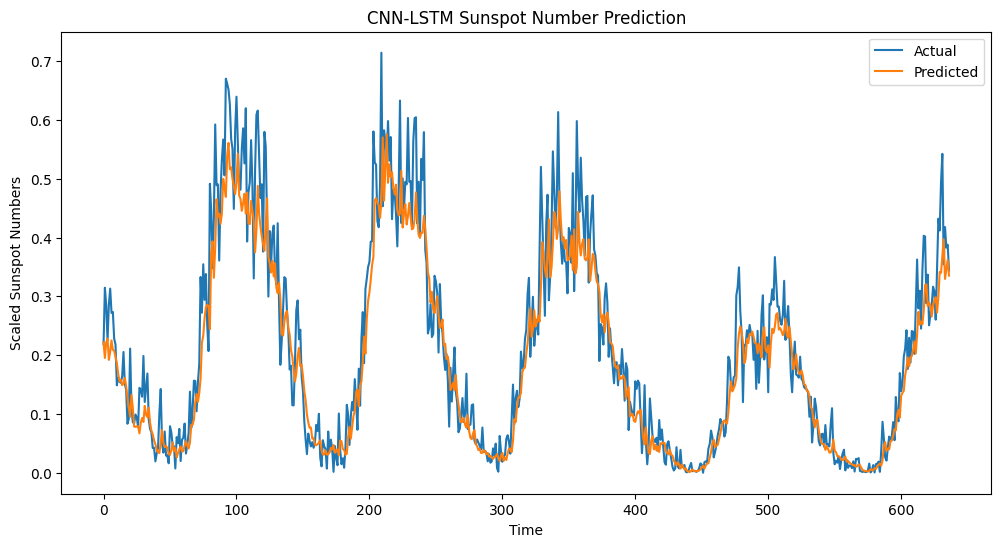

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Input
from tensorflow.keras.optimizers import Adam

# Define the CNN-LSTM model
def build_cnn_lstm_model(sequence_length, n_features):
    model = Sequential([
        Input(shape=(sequence_length, n_features)),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Set parameters
sequence_length = 132
n_features = 1
epochs = 100
batch_size = 32

# # Reshape the input data
# X_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
# X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))

# Build and train the model
model_cnn_lstm = build_cnn_lstm_model(sequence_length, n_features)
history = model_cnn_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss = model_cnn_lstm.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model_cnn_lstm.predict(X_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('CNN-LSTM Sunspot Number Prediction')
plt.xlabel('Time')
plt.ylabel('Scaled Sunspot Numbers')
plt.legend()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 24.194


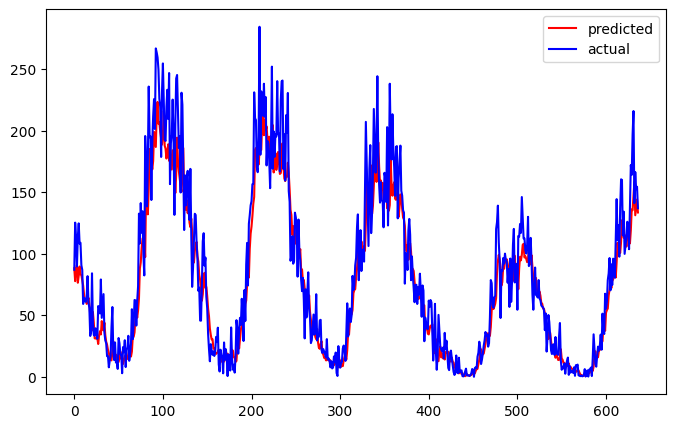

In [ ]:
originalData=np.array(df_m["ssn_m"])
predictions = model_cnn_lstm.predict(X_test)
predictions_rescaled = minmaxDeNorm( originalData, predictions)
len(predictions_rescaled),len(y_test)
y_test_rescaled = minmaxDeNorm(originalData, y_test)
plt.figure(figsize=(8,5))
plt.plot(predictions_rescaled,c="r")
plt.plot(y_test_rescaled,c="b")
plt.legend(["predicted","actual"])

from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"RMSE: {rmse:.3f}")

In [ ]:
# Save the trained model
model.save('sunspot_CNN_lstm_model.keras')

<a id="rnn"></a>
###RNN

Basic Recurrent Neural Network. Often struggles with long-term dependencies compared to LSTM/GRU.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,GRU,LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,GRU,LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
def build_rnn():
  model = Sequential([
                      SimpleRNN(units=50, activation='tanh', return_sequences=True, input_shape = (x_train.shape[1],1)),
                      Dropout(0.2),
                      SimpleRNN(units=50, activation='tanh'),
                      Dropout(0,2),
                      Dense(units=1)
                      ])
  model.compile(optimizer=Adam(learning_rate=0.001),loss="mse")
  return model
rnn_model = build_rnn()
rnn_history = rnn_model.fit(X_train, y_train, epochs = 100, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - loss: 0.0436 - val_loss: 0.0044
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0071 - val_loss: 0.0042
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 0.0062 - val_loss: 0.0035
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0044 - val_loss: 0.0072
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.0056 - val_loss: 0.0038
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - 

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


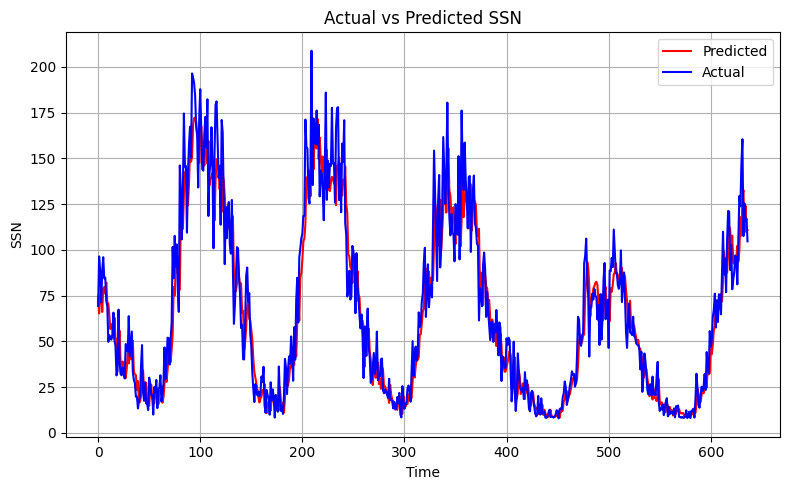

RMSE: 15.971
MAE: 11.622
R² Score: 0.894


In [ ]:
originalData=np.array(df_m["ssn_m"])
predictions = rnn_model.predict(X_test)

predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_test_denorm = scaler.inverse_transform(y_test)
predictions_denorm = scaler.inverse_transform(predictions)

plt.figure(figsize=(8,5))
plt.plot(predictions_denorm, c="r")
plt.plot(y_test_denorm, c="b")
plt.legend(["Predicted", "Actual"])
plt.title("Actual vs Predicted SSN")
plt.xlabel("Time")
plt.ylabel("SSN")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions_denorm))
mae = mean_absolute_error(y_test_denorm, predictions_denorm)
r2 = r2_score(y_test_denorm, predictions_denorm)

# Print metrics
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

<a id="gru"></a>
###GRU

GRU (Gated Recurrent Unit) is a fast, efficient RNN variant that captures sequence patterns with fewer parameters than LSTM. We use GRU to forecast sunspot numbers and compare its results to other models.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense
# Define the GRU model
def build_gru_model(sequence_length, n_features):
    model = Sequential([
        Input(shape=(sequence_length, n_features)),  # ✅ No warning
        GRU(256, activation='relu', return_sequences=True),
        GRU(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.0212 - val_loss: 0.0060
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0046 - val_loss: 0.0067
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/ste

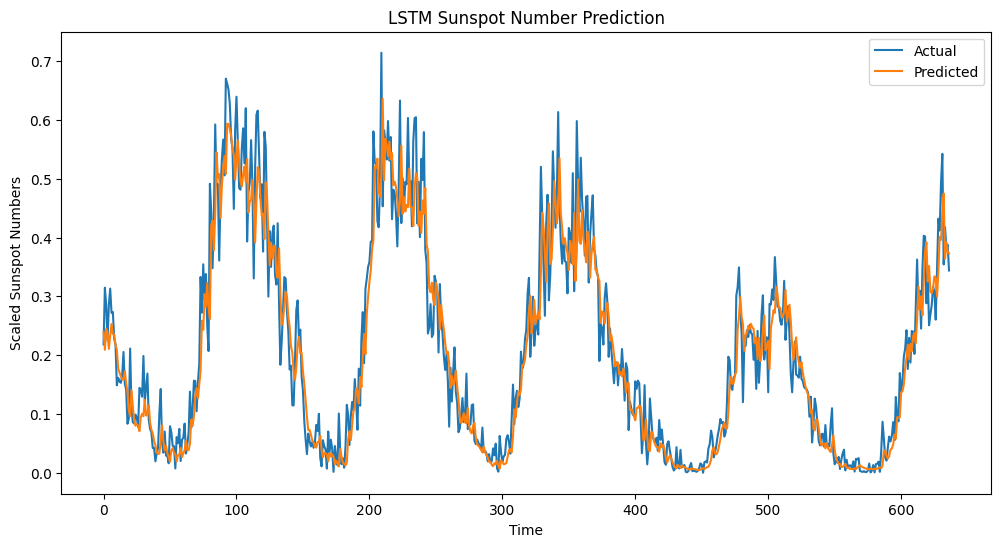

In [ ]:
# Set parameters
sequence_length = 132
n_features = 1
epochs = 100
batch_size = 32

# Build and train the model
model_gru = build_gru_model(sequence_length, n_features)
history = model_gru.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss = model_gru.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model_gru.predict(X_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Sunspot Number Prediction')
plt.xlabel('Time')
plt.ylabel('Scaled Sunspot Numbers')
plt.legend()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


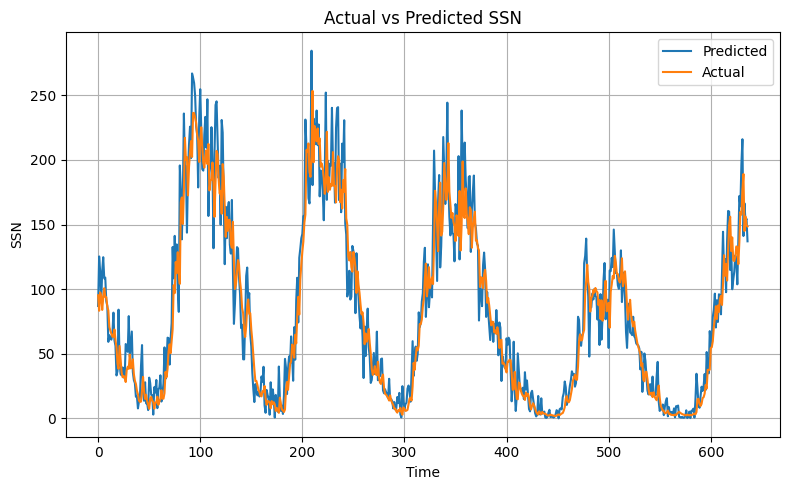

RMSE: 22.435
MAE: 16.004
R² Score: 0.895


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predictions = model_gru.predict(X_test)

predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_test_denorm = scaler.inverse_transform(y_test)
predictions_denorm = scaler.inverse_transform(predictions)

plt.figure(figsize=(8,5))
plt.plot(y_test_denorm)
plt.plot(predictions_denorm)

plt.legend(["Predicted", "Actual"])
plt.title("Actual vs Predicted SSN")
plt.xlabel("Time")
plt.ylabel("SSN")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions_denorm))
mae = mean_absolute_error(y_test_denorm, predictions_denorm)
r2 = r2_score(y_test_denorm, predictions_denorm)

# Print metrics
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

<a id="time-series-forecasting"></a>
# Time series forecasting
We have forecasted the sun spot numbers from
Jan 2025- Dec 2035 using the saved models.

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

<ipython-input-27-1159c6d3099d>:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=seq_length, freq='M')


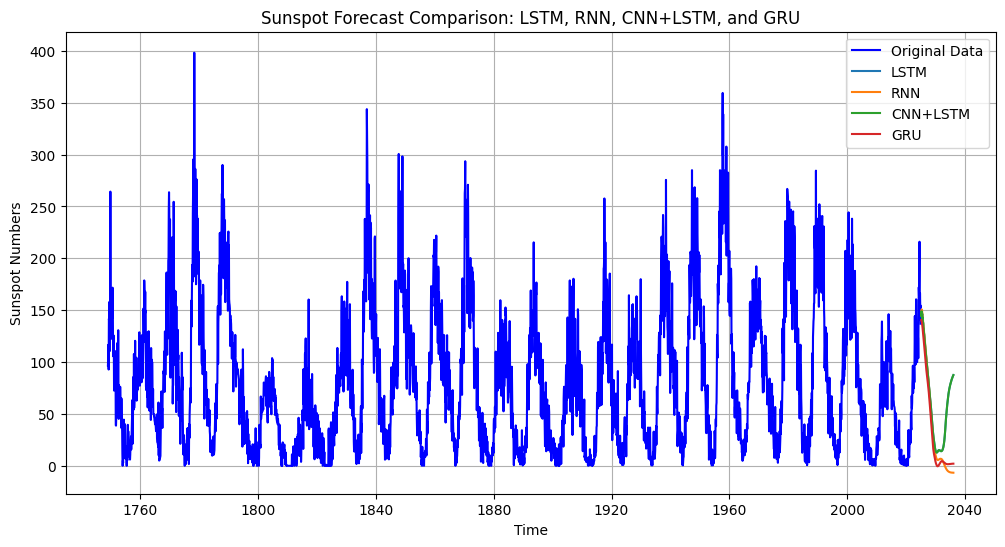

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Assume df_m is your DataFrame with the historical data

# Ensure that df_m["time"] is in datetime format and df_m["ssn_m"] contains original sunspot numbers
df_m["time"] = pd.to_datetime(df_m["time"])

# Assume you have a fitted scaler from training that you can use to invert your scaling.
# If not, reinitialize using the same parameters.
scaler = MinMaxScaler()

df_m["scaled_ssn"] = scaler.fit_transform(df_m[['ssn_m']])

# Define the sequence length for forecasting (example: 132 months)
seq_length = 132
data = df_m["scaled_ssn"].values

# Define file paths and load multiple models
lstm_model = load_model('/content/drive/MyDrive/DL_project/sunspot_CNN_lstm_model.keras')
rnn_model =load_model('/content/drive/MyDrive/DL_project/sunspot_rnn_model.keras')
cnn_lstm_model = load_model('/content/drive/MyDrive/DL_project/sunspot_CNN_lstm_model.keras')
gru_model = load_model('/content/sunspot_gru_model.keras')
models = {
    "LSTM":lstm_model,
    "RNN": rnn_model,
    "CNN+LSTM": cnn_lstm_model,
    "GRU": gru_model
}

# Dictionary to store forecasts (original scale) for each model
forecasts = {}

# Generate forecast for each model independently
for model_name, model in models.items():
    # Get the last seq_length points for the initial sequence
    current_sequence = data[-seq_length:].reshape(1, seq_length, 1)
    forecast_scaled = []

    # Iterate to predict next seq_length steps
    for _ in range(seq_length):
        next_value = model.predict(current_sequence)
        # Append the predicted value (assumed to be of shape (1, 1))
        forecast_scaled.append(next_value[0, 0])
        # Update sequence: drop the first value and add the new prediction
        next_value_reshaped = next_value.reshape(1, 1, 1)
        current_sequence = np.concatenate((current_sequence[:, 1:, :], next_value_reshaped), axis=1)

    # Convert predictions to a numpy array and inverse-transform back to original scale
    forecast_scaled = np.array(forecast_scaled).reshape(-1, 1)
    forecast_original = scaler.inverse_transform(forecast_scaled).flatten()
    forecasts[model_name] = forecast_original

# Prepare the forecast DataFrame with dates.
# Start one month after the last available data point.
last_date = df_m["time"].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=seq_length, freq='M')
forecast_df = pd.DataFrame({"new_date": forecast_dates})

# Plot the original data and forecast of each model
plt.figure(figsize=(12, 6))
start_idx = int(len(df_m) * 0.8)

# Plot the last 20% of the data
plt.plot(df_m["time"].iloc[start_idx:], df_m["ssn_m"].iloc[start_idx:], label='Last 20% Data', color='blue')
# plt.plot(df_m["time"], df_m["ssn_m"], label='Original Data', color='blue')

# Plot each model forecast
for model_name, forecast in forecasts.items():
    plt.plot(forecast_df["new_date"], forecast, label=model_name)

plt.xlabel("Time")
plt.ylabel("Sunspot Numbers")
plt.title("Sunspot Forecast Comparison: LSTM, RNN, CNN+LSTM, and GRU")
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-29-c57e0adc9bda>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=seq_length, freq='M')


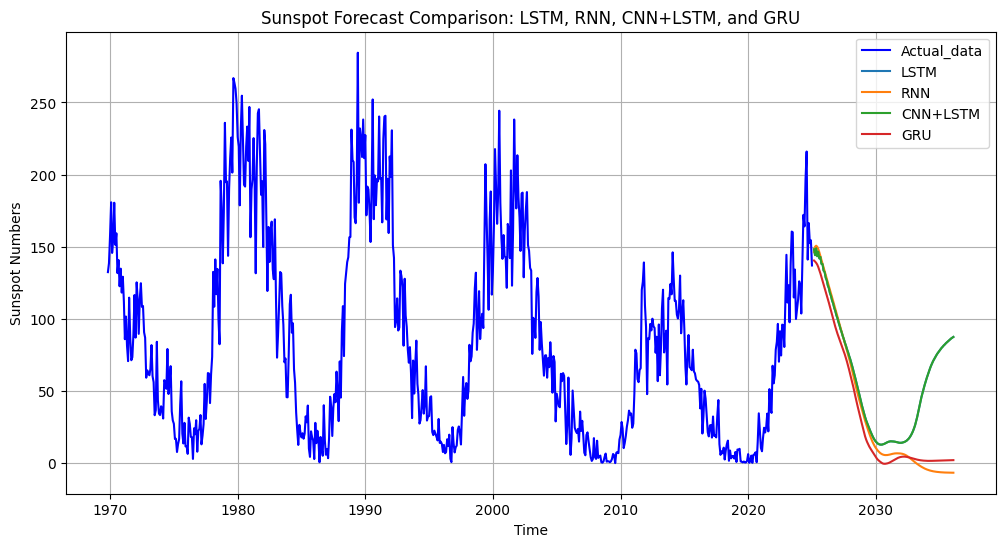

In [ ]:
# Prepare the forecast DataFrame with dates.
# Start one month after the last available data point.
last_date = df_m["time"].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=seq_length, freq='M')
forecast_df = pd.DataFrame({"new_date": forecast_dates})

# Plot the original data and forecast of each model
plt.figure(figsize=(12, 6))
start_idx = int(len(df_m) * 0.8)

# Plot the last 20% of the data
plt.plot(df_m["time"].iloc[start_idx:], df_m["ssn_m"].iloc[start_idx:], label='Actual_data', color='blue')
# plt.plot(df_m["time"], df_m["ssn_m"], label='Original Data', color='blue')

# Plot each model forecast
for model_name, forecast in forecasts.items():
    plt.plot(forecast_df["new_date"], forecast, label=model_name)

plt.xlabel("Time")
plt.ylabel("Sunspot Numbers")
plt.title("Sunspot Forecast Comparison: LSTM, RNN, CNN+LSTM, and GRU")
plt.legend()
plt.grid(True)
plt.show()

<a id="residual-data-analysis"></a>
# Residual Data Analysis
The residual data represents the unexplained variation in the sunspot numbers after accounting for the trend and seasonality. Analyzing this data can provide insights into the underlying noise or any
remaining patterns not captured by the initial decomposition.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

d =pd.read_csv(r"/content/SN_m_tot_V2.0 (1).csv")

ssn= [96.7]
year=[1749]
month = [1]

for i in range(len(d)):
    ssn.append(float(d['1749;01;1749.042;  96.7; -1.0;   -1;1'][i][18:23]))
    year.append(str(d['1749;01;1749.042;  96.7; -1.0;   -1;1'][i][:4]))
    month.append(int(d['1749;01;1749.042;  96.7; -1.0;   -1;1'][i][5:7]))

df = pd.DataFrame()
df["ssn"] = ssn
df["year"]=year

df["month"]=month

date = []
for i in range(len(df)):
    date.append(str(df["year"][i]) + "-" +str(df["month"][i]))
df["date"] = date
df["date"] = pd.to_datetime(df["date"])


import numpy as np

# Make times manageable (Scargle periodogram is time-shift invariant)
# time = t - t[0]
# n0=len(time)
# #fmin=1.0/np.max(time)
# fmax = n0 / (2.0 * np.max(time))#nyquist rate
# #print(fmax)

# Assuming 't' is your time array and 'signal' is your data array
# Use a 11-point, order 0, and second degree Savitzky-Golay Filter
y=list(df['ssn'])
from scipy.signal import savgol_filter
window_size = 95
order = 2
sy = savgol_filter(y, window_size, order)
#stime=savgol_filter(t, window_size, order)
# Now, 'savgol_filtered_signal' contains the Savitzky-Golay filtered version of your data
fy=y-sy #residual
df['residual_ssn']=fy
df['smooth_ssn']=sy

<a id="scale-the-residual-data"></a>
## Scale the residual data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler =MinMaxScaler()
df["scaled_residual"]  = scaler.fit_transform(df[['residual_ssn']])
df

ssn  year  month       date  residual_ssn  smooth_ssn  scaled_residual
0      96.7  1749      1 1749-01-01    -60.518634  157.218634         0.114925
1     104.3  1749      2 1749-02-01    -50.460625  154.760625         0.147643
2     116.7  1749      3 1749-03-01    -35.620476  152.320476         0.195916
3      92.8  1749      4 1749-04-01    -57.098188  149.898188         0.126052
4     141.7  1749      5 1749-05-01     -5.793760  147.493760         0.292938
...     ...   ...    ...        ...           ...         ...              ...
3308  141.1  2024      9 2024-09-01    -30.952255  172.052255         0.211101
3309  166.4  2024     10 2024-10-01    -10.475592  176.875592         0.277708
3310  152.5  2024     11 2024-11-01    -29.267762  181.767762         0.216580
3311  154.5  2024     12 2024-12-01    -32.228765  186.728765         0.206948
3312  137.0  2025      1 2025-01-01    -54.758600  191.758600         0.133662

[3313 rows x 7 columns]

In [ ]:
df.head()

ssn  year  month       date  residual_ssn  smooth_ssn
0   96.7  1749      1 1749-01-01    -60.518634  157.218634
1  104.3  1749      2 1749-02-01    -50.460625  154.760625
2  116.7  1749      3 1749-03-01    -35.620476  152.320476
3   92.8  1749      4 1749-04-01    -57.098188  149.898188
4  141.7  1749      5 1749-05-01     -5.793760  147.493760

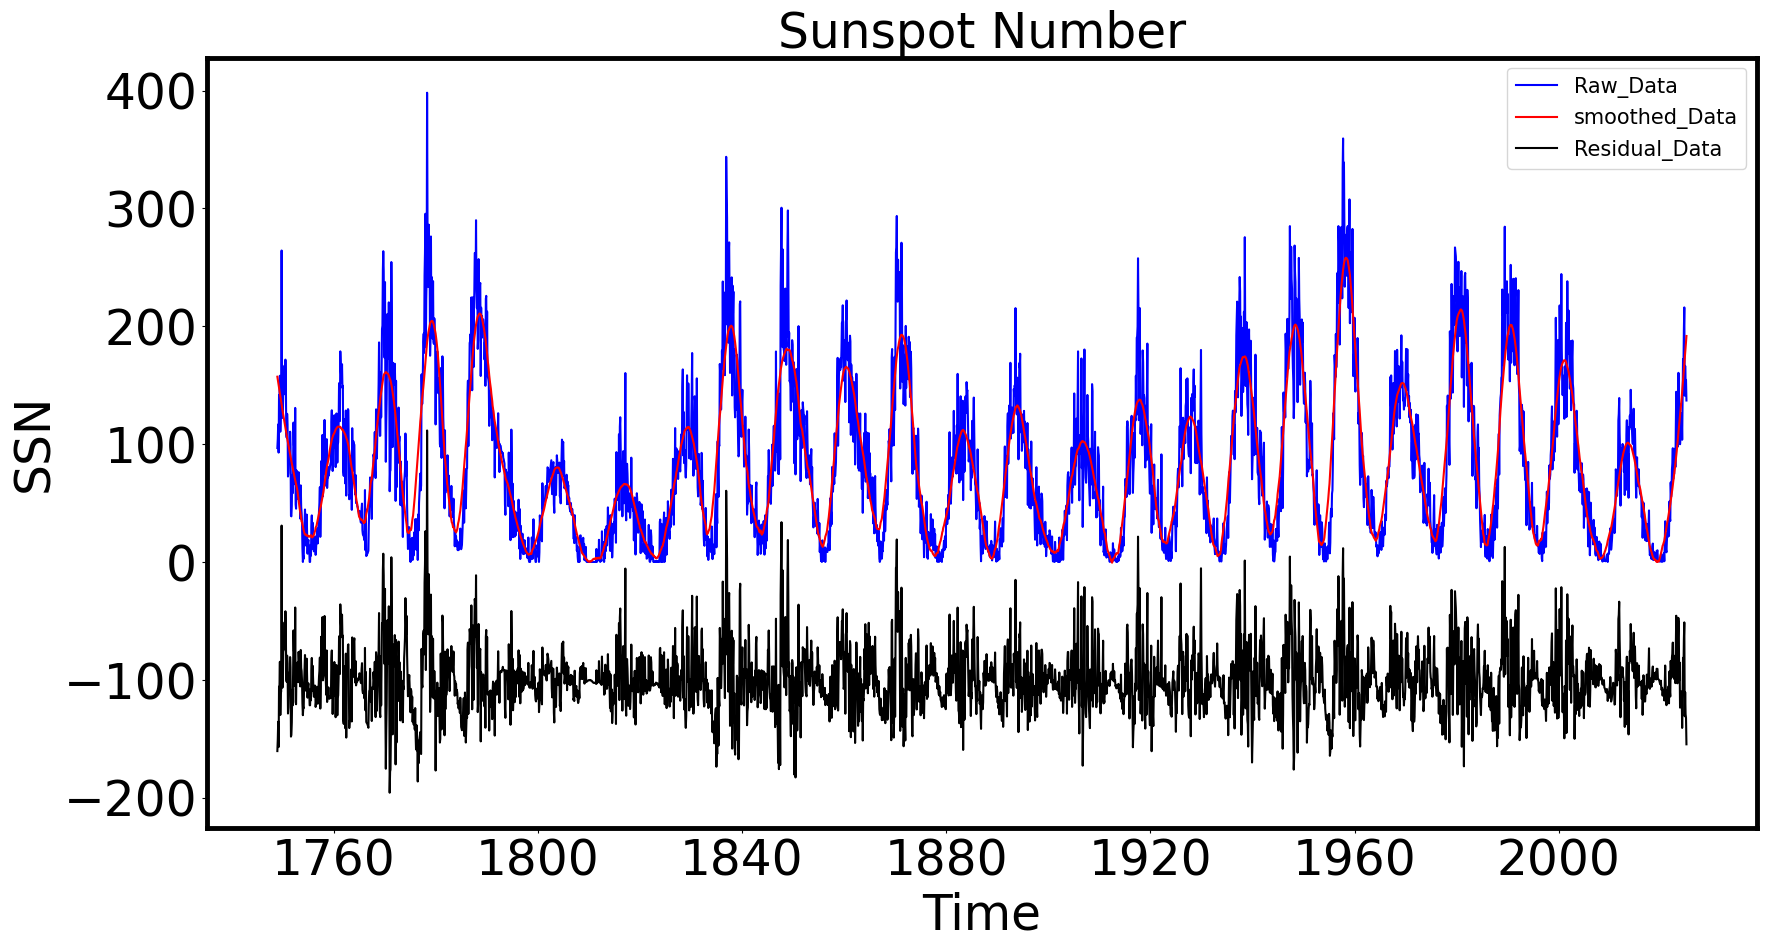

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(df['date'], df.ssn, label='Original Data', color='blue')

# Plot the Savitzky-Golay filtered signal
plt.plot(df['date'],sy,label='Savitzky-Golay Filtered Signal', color='red')
#plot final signal after substractin y and sy
plt.plot(df['date'], np.array(fy)-100, label='residual', color='black')

# Add labels and a legend
for spine in plt.gca().spines.values():
    spine.set_linewidth(3.5)

plt.tick_params(axis='x', labelsize=35)
plt.tick_params(axis='y', labelsize=35)
plt.title("Sunspot Number" ,size =35)
plt.xlabel('Time' , size=35)
plt.ylabel('SSN',size =35)
plt.legend(["Raw_Data" , "smoothed_Data","Residual_Data"],fontsize=15)

# Show the plot
plt.show()

<a id="create-sequences-for-residual-data"></a>
## Create sequences for residual data

In [ ]:
def create_sequence(data,seq_length):
  x=[]
  y=[]
  for i in range(len(data)-seq_length):
    x.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
  return np.array(x),np.array(y)

In [ ]:
data = df["scaled_residual"]
seq_length = 60
x,y = create_sequence(data,seq_length)
x.shape , y.shape

((3253, 60), (3253,))

In [ ]:
df

ssn  year  month       date  residual_ssn  smooth_ssn  scaled_residual
0      96.7  1749      1 1749-01-01    -60.518634  157.218634         0.114925
1     104.3  1749      2 1749-02-01    -50.460625  154.760625         0.147643
2     116.7  1749      3 1749-03-01    -35.620476  152.320476         0.195916
3      92.8  1749      4 1749-04-01    -57.098188  149.898188         0.126052
4     141.7  1749      5 1749-05-01     -5.793760  147.493760         0.292938
...     ...   ...    ...        ...           ...         ...              ...
3308  141.1  2024      9 2024-09-01    -30.952255  172.052255         0.211101
3309  166.4  2024     10 2024-10-01    -10.475592  176.875592         0.277708
3310  152.5  2024     11 2024-11-01    -29.267762  181.767762         0.216580
3311  154.5  2024     12 2024-12-01    -32.228765  186.728765         0.206948
3312  137.0  2025      1 2025-01-01    -54.758600  191.758600         0.133662

[3313 rows x 7 columns]

In [ ]:
dft = pd.DataFrame(x)
dft.head()

0         1         2         3         4         5         6   \
0  0.114925  0.147643  0.195916  0.126052  0.292938  0.292569  0.361427   
1  0.147643  0.195916  0.126052  0.292938  0.292569  0.361427  0.214564   
2  0.195916  0.126052  0.292938  0.292569  0.361427  0.214564  0.274198   
3  0.126052  0.292938  0.292569  0.361427  0.214564  0.274198  0.279452   
4  0.292938  0.292569  0.361427  0.214564  0.274198  0.279452  0.737445   

         7         8         9   ...        50        51        52        53  \
0  0.214564  0.274198  0.279452  ...  0.388735  0.357506  0.355126  0.340504   
1  0.274198  0.279452  0.737445  ...  0.357506  0.355126  0.340504  0.293442   
2  0.279452  0.737445  0.347035  ...  0.355126  0.340504  0.293442  0.394067   
3  0.737445  0.347035  0.289985  ...  0.340504  0.293442  0.394067  0.344210   
4  0.347035  0.289985  0.311271  ...  0.293442  0.394067  0.344210  0.336219   

         54        55        56        57        58        59  
0  0.293442  0.394067  0.344210  0.336219  0.308695  0.244735  
1  0.394067  0.344210  0.336219  0.308695  0.244735  0.214036  
2  0.344210  0.336219  0.308695  0.244735  0.214036  0.235785  
3  0.336219  0.308695  0.244735  0.214036  0.235785  0.233659  
4  0.308695  0.244735  0.214036  0.235785  0.233659  0.302907  

[5 rows x 60 columns]

<a id="split-the-data"></a>
## Split the data

In [ ]:
x_train = x[:int(0.8*len(x))]
x_test = x[int(0.8*len(x)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2602, 60)
(651, 60)
(2602,)
(651,)


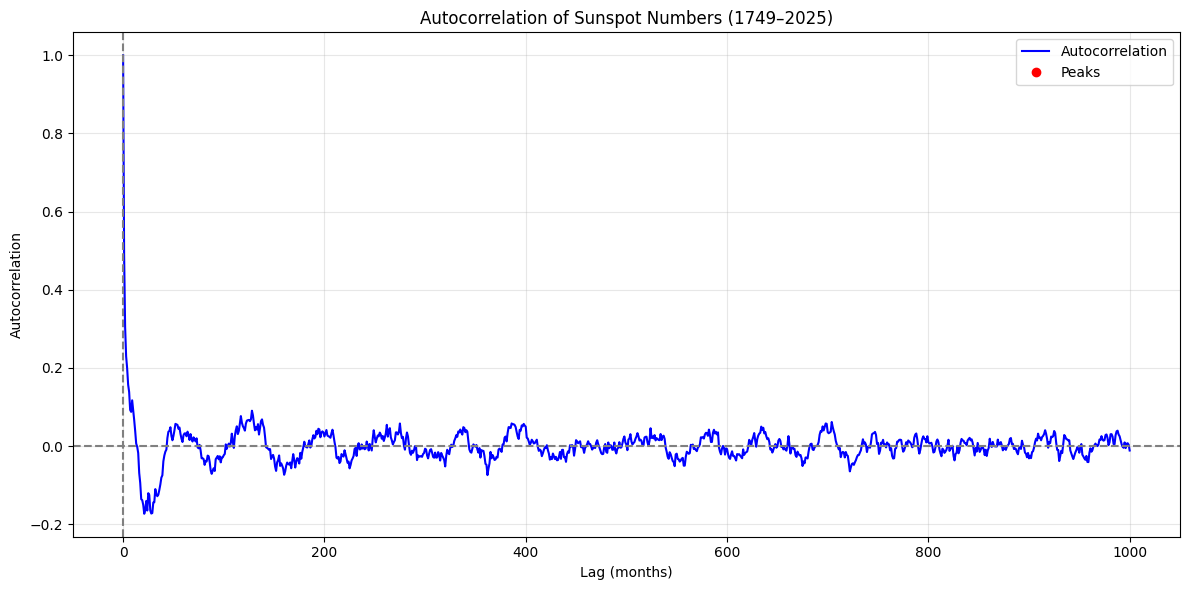

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import scipy.signal as signal

# Calculate autocorrelation with maximum lag of 20 years (340 months)
def detect_sunspot_periodicity(data, max_lag=1000):
    # Calculate autocorrelation function
    acf_values = acf(data, nlags=max_lag, fft=True)
    lags = np.arange(len(acf_values))

    # Find peaks in autocorrelation
    peaks, _ = signal.find_peaks(acf_values, height=0.2, distance=30)

    return lags, acf_values, peaks

# Convert time to datetime index if not already
# df_m['time'] = pd.to_datetime(df_m['time'])
# df_m.set_index('time', inplace=True)

# Apply to sunspot data
lags, acf_values, peaks = detect_sunspot_periodicity(df['residual_ssn'])

# Plot autocorrelation with peaks
plt.figure(figsize=(12, 6))
plt.plot(lags, acf_values, 'b-', label='Autocorrelation')
plt.plot(lags[peaks], acf_values[peaks], 'ro', label='Peaks')

# Add reference lines
plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=0, color='gray', linestyle='--')

# Annotate the first peak (ignoring lag=0)
if len(peaks) > 0:
    first_peak = peaks[0]
    months = lags[first_peak]
    plt.annotate(f'{months} months\n({months/12:.1f} years)',
                 xy=(months, acf_values[first_peak]),
                 xytext=(0, 20),
                 textcoords='offset points',
                 ha='center',
                 arrowprops=dict(arrowstyle='->'))

plt.title('Autocorrelation of Sunspot Numbers (1749–2025)')
plt.xlabel('Lag (months)')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()




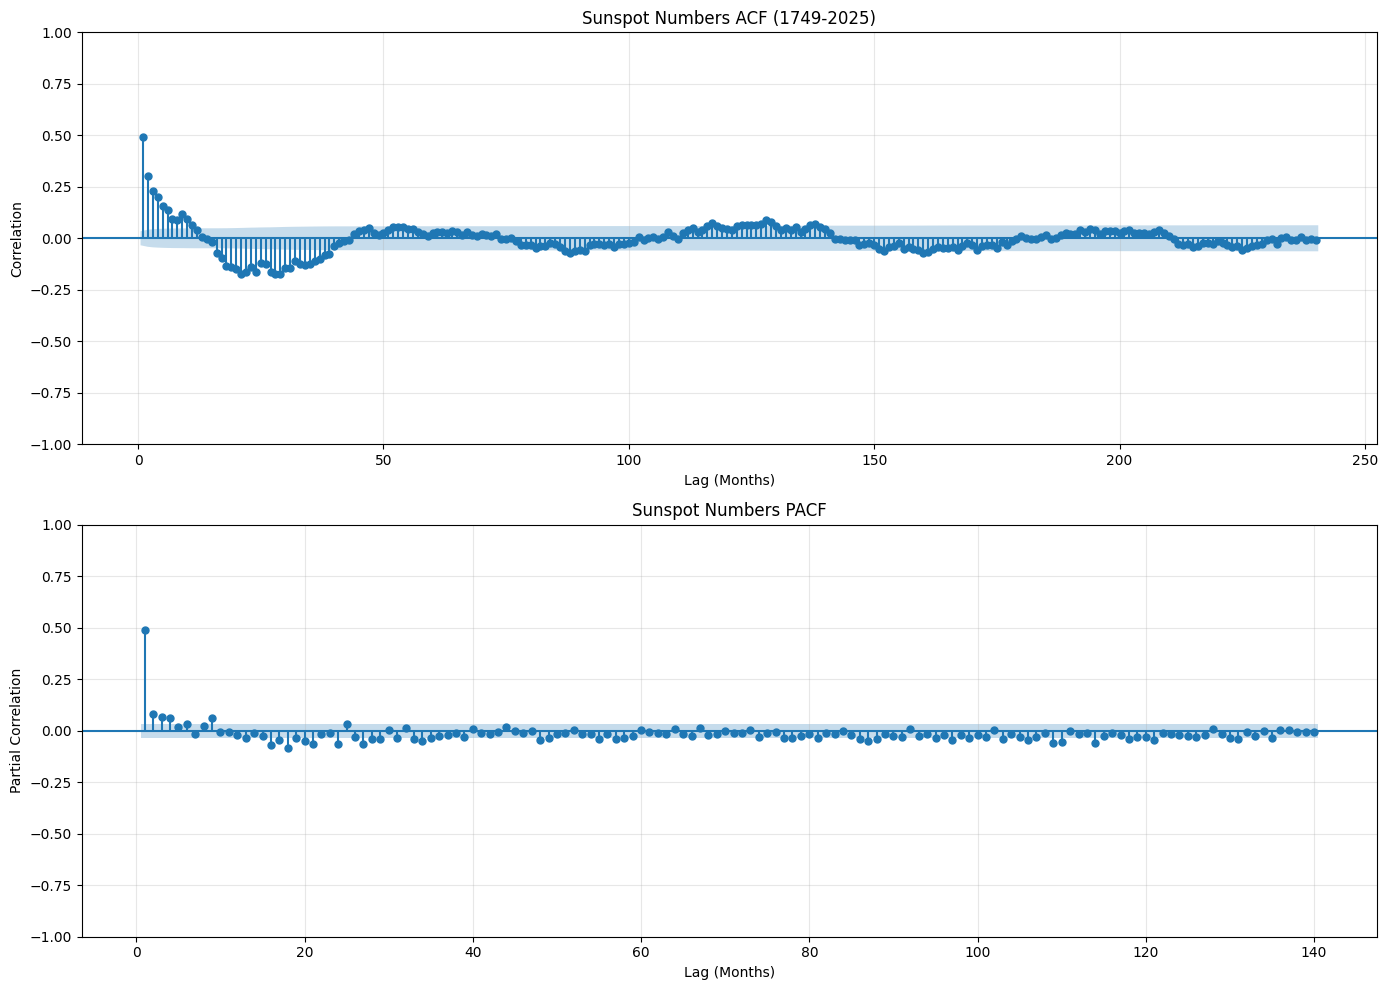

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create combined ACF/PACF plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# ACF Plot (Focus on 20-year period)
plot_acf(df['residual_ssn'],
         lags=240,  # 20 years (240 months)
         alpha=0.05,  # 95% confidence interval
         title='Sunspot Numbers ACF (1749-2025)',
         ax=ax1,
         zero=False)
ax1.set_xlabel('Lag (Months)')
ax1.set_ylabel('Correlation')
ax1.grid(True, alpha=0.3)

# PACF Plot (First 5 years for AR order identification)
plot_pacf(df['residual_ssn'],
          lags=140,  # 20 years (240 months)
          alpha=0.05,
          title='Sunspot Numbers PACF',
          ax=ax2,
          zero=False)
ax2.set_xlabel('Lag (Months)')
ax2.set_ylabel('Partial Correlation')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Augmented Dickey-Fuller Test

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss

# Custom function for ADF test
def adf_test(timeseries):
    print("=== Augmented Dickey-Fuller Test ===")
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] < 0.05:
        print("Strong evidence against null hypothesis")
        print("Conclusion: Series is STATIONARY")
    else:
        print("Weak evidence against null hypothesis")
        print("Conclusion: Series is NON-STATIONARY")
# Example: Check stationarity of the raw sunspot-like data
adf_test(df['residual_ssn'])

=== Augmented Dickey-Fuller Test ===
ADF Statistic: -15.0270
p-value: 0.0000
Critical Values:
	1%: -3.4323
	5%: -2.8624
	10%: -2.5672
Strong evidence against null hypothesis
Conclusion: Series is STATIONARY


KPSS Test

In [ ]:
# Custom function for KPSS test
def kpss_test(timeseries):
    print("\n=== KPSS Test ===")
    result = kpss(timeseries, regression='c', nlags='auto')
    print(f'KPSS Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] < 0.05:
        print("Strong evidence against null hypothesis")
        print("Conclusion: Series is NON-STATIONARY")
    else:
        print("Weak evidence against null hypothesis")
        print("Conclusion: Series is STATIONARY")
kpss_test(df['residual_ssn'])


=== KPSS Test ===
KPSS Statistic: 0.0033
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Weak evidence against null hypothesis
Conclusion: Series is STATIONARY


<ipython-input-53-a4ea8c2fc155>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(timeseries, regression='c', nlags='auto')


<a id="gaussian-or-non-gaussian-distribution"></a>
## Gaussian Or Non Gaussian Distribution

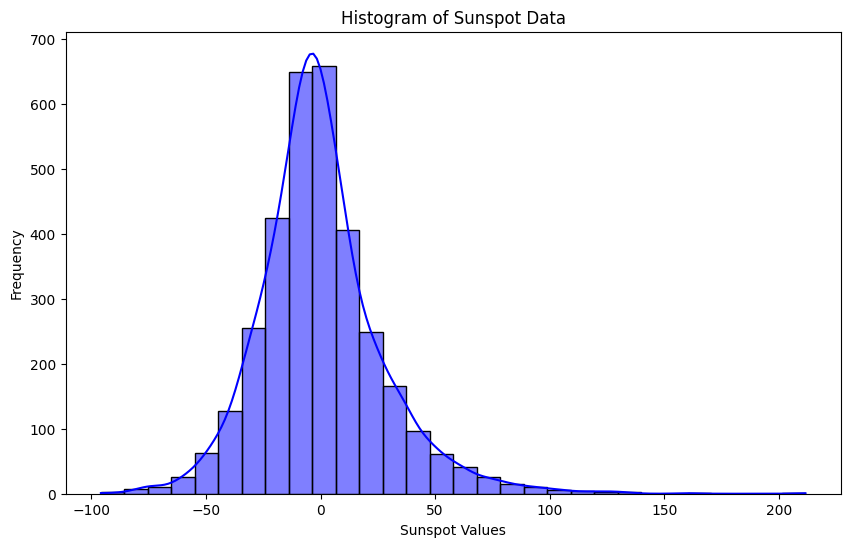

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the scaled sunspot data for visualization
flattened_data = df["residual_ssn"].values.flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(flattened_data, kde=True, bins=30, color='blue')
plt.title('Histogram of Sunspot Data')
plt.xlabel('Sunspot Values')
plt.ylabel('Frequency')
plt.show()


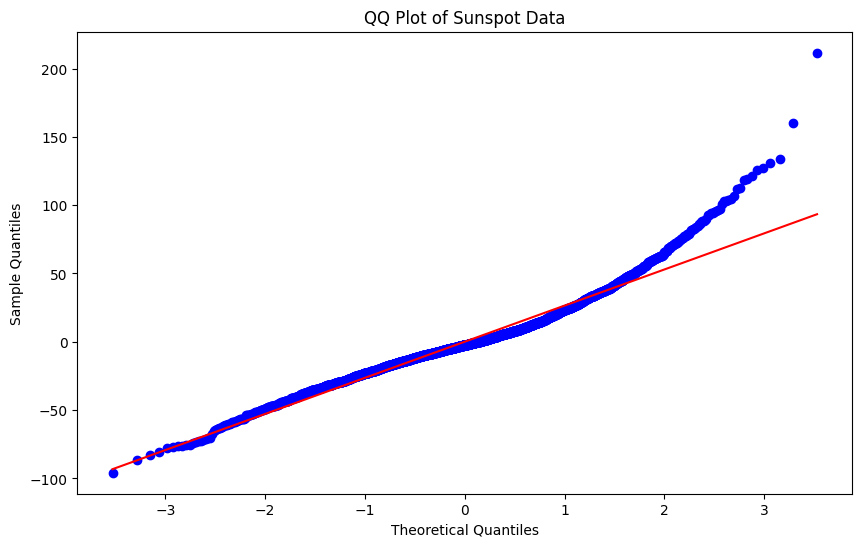

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Generate QQ plot
plt.figure(figsize=(10, 6))
stats.probplot(flattened_data, dist="norm", plot=plt)
plt.title("QQ Plot of Sunspot Data")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()


<a id="lstm-on-residual-data"></a>
## LSTM on Residual Data

In [ ]:
def create_supervised_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_supervised_data(df["scaled_residual"], window_size=60)
# X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
df

ssn  year  month       date  residual_ssn  smooth_ssn  scaled_residual
0      96.7  1749      1 1749-01-01    -60.518634  157.218634         0.114925
1     104.3  1749      2 1749-02-01    -50.460625  154.760625         0.147643
2     116.7  1749      3 1749-03-01    -35.620476  152.320476         0.195916
3      92.8  1749      4 1749-04-01    -57.098188  149.898188         0.126052
4     141.7  1749      5 1749-05-01     -5.793760  147.493760         0.292938
...     ...   ...    ...        ...           ...         ...              ...
3308  141.1  2024      9 2024-09-01    -30.952255  172.052255         0.211101
3309  166.4  2024     10 2024-10-01    -10.475592  176.875592         0.277708
3310  152.5  2024     11 2024-11-01    -29.267762  181.767762         0.216580
3311  154.5  2024     12 2024-12-01    -32.228765  186.728765         0.206948
3312  137.0  2025      1 2025-01-01    -54.758600  191.758600         0.133662

[3313 rows x 7 columns]

In [ ]:
Xo, yo = create_supervised_data(df["ssn"], window_size=60)
yo_test = yo[int(0.8*len(yo)):]
Xs, ys = create_supervised_data(df["smooth_ssn"], window_size=60)
ys_test = ys[int(0.8*len(ys)):]

In [ ]:
df

ssn  year  month       date  residual_ssn  smooth_ssn  scaled_residual
0      96.7  1749      1 1749-01-01    -60.518634  157.218634         0.114925
1     104.3  1749      2 1749-02-01    -50.460625  154.760625         0.147643
2     116.7  1749      3 1749-03-01    -35.620476  152.320476         0.195916
3      92.8  1749      4 1749-04-01    -57.098188  149.898188         0.126052
4     141.7  1749      5 1749-05-01     -5.793760  147.493760         0.292938
...     ...   ...    ...        ...           ...         ...              ...
3308  141.1  2024      9 2024-09-01    -30.952255  172.052255         0.211101
3309  166.4  2024     10 2024-10-01    -10.475592  176.875592         0.277708
3310  152.5  2024     11 2024-11-01    -29.267762  181.767762         0.216580
3311  154.5  2024     12 2024-12-01    -32.228765  186.728765         0.206948
3312  137.0  2025      1 2025-01-01    -54.758600  191.758600         0.133662

[3313 rows x 7 columns]

In [ ]:
pd.DataFrame(X)

0         1         2         3         4         5         6   \
0     0.114925  0.147643  0.195916  0.126052  0.292938  0.292569  0.361427   
1     0.147643  0.195916  0.126052  0.292938  0.292569  0.361427  0.214564   
2     0.195916  0.126052  0.292938  0.292569  0.361427  0.214564  0.274198   
3     0.126052  0.292938  0.292569  0.361427  0.214564  0.274198  0.279452   
4     0.292938  0.292569  0.361427  0.214564  0.274198  0.279452  0.737445   
...        ...       ...       ...       ...       ...       ...       ...   
3248  0.310294  0.305258  0.300571  0.298930  0.309221  0.284854  0.283663   
3249  0.305258  0.300571  0.298930  0.309221  0.284854  0.283663  0.289701   
3250  0.300571  0.298930  0.309221  0.284854  0.283663  0.289701  0.268013   
3251  0.298930  0.309221  0.284854  0.283663  0.289701  0.268013  0.283635   
3252  0.309221  0.284854  0.283663  0.289701  0.268013  0.283635  0.280422   

            7         8         9   ...        50        51        52  \
0     0.214564  0.274198  0.279452  ...  0.388735  0.357506  0.355126   
1     0.274198  0.279452  0.737445  ...  0.357506  0.355126  0.340504   
2     0.279452  0.737445  0.347035  ...  0.355126  0.340504  0.293442   
3     0.737445  0.347035  0.289985  ...  0.340504  0.293442  0.394067   
4     0.347035  0.289985  0.311271  ...  0.293442  0.394067  0.344210   
...        ...       ...       ...  ...       ...       ...       ...   
3248  0.289701  0.268013  0.283635  ...  0.245085  0.252453  0.279439   
3249  0.268013  0.283635  0.280422  ...  0.252453  0.279439  0.255782   
3250  0.283635  0.280422  0.280847  ...  0.279439  0.255782  0.178880   
3251  0.280422  0.280847  0.254687  ...  0.255782  0.178880  0.272853   
3252  0.280847  0.254687  0.292591  ...  0.178880  0.272853  0.372459   

            53        54        55        56        57        58        59  
0     0.340504  0.293442  0.394067  0.344210  0.336219  0.308695  0.244735  
1     0.293442  0.394067  0.344210  0.336219  0.308695  0.244735  0.214036  
2     0.394067  0.344210  0.336219  0.308695  0.244735  0.214036  0.235785  
3     0.344210  0.336219  0.308695  0.244735  0.214036  0.235785  0.233659  
4     0.336219  0.308695  0.244735  0.214036  0.235785  0.233659  0.302907  
...        ...       ...       ...       ...       ...       ...       ...  
3248  0.255782  0.178880  0.272853  0.372459  0.331642  0.422992  0.470205  
3249  0.178880  0.272853  0.372459  0.331642  0.422992  0.470205  0.211101  
3250  0.272853  0.372459  0.331642  0.422992  0.470205  0.211101  0.277708  
3251  0.372459  0.331642  0.422992  0.470205  0.211101  0.277708  0.216580  
3252  0.331642  0.422992  0.470205  0.211101  0.277708  0.216580  0.206948  

[3253 rows x 60 columns]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense
# Define the LSTM model
def build_lstm_model(sequence_length, n_features):
    model = Sequential([
        Input(shape=(sequence_length, n_features)),  # ✅ No warning
        LSTM(256, activation='relu', return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0296 - val_loss: 0.0084
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0079 - val_loss: 0.0088
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0074 - val_loss: 0.0082
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0063 - val_loss: 0.0080
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0066 - val_loss: 0.0082
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0068 - val_loss: 0.0077
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0070 - val_loss: 0.0076
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0065 - val_loss: 0.0080
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0065 - val_loss: 0.0075
Epoch 12/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

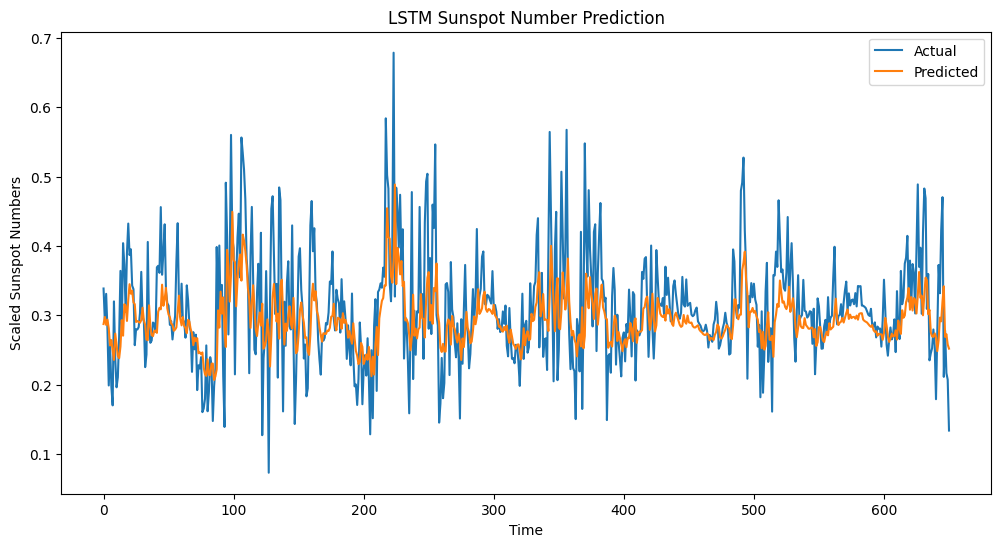

In [ ]:

# Set parameters
sequence_length = 60
n_features = 1
epochs = 100
batch_size = 32

# Reshape the input data for LSTM (samples, time steps, features)



# Build and train the model
model_lstm = build_lstm_model(sequence_length, n_features)
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model_lstm.predict(X_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Sunspot Number Prediction')
plt.xlabel('Time')
plt.ylabel('Scaled Sunspot Numbers')
plt.legend()
plt.show()



21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


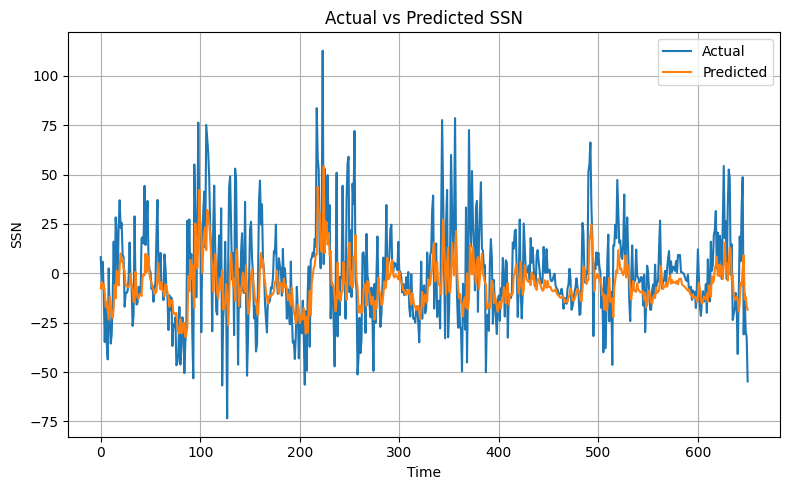

RMSE: 21.586
MAE: 15.557
R² Score: 0.206


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
originalData=np.array(df["residual_ssn"])
predictions = model_lstm.predict(X_test)
predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_test_denorm = scaler.inverse_transform(y_test)
predictions_denorm = scaler.inverse_transform(predictions)

plt.figure(figsize=(8,5))
plt.plot(y_test_denorm)
plt.plot(predictions_denorm)
plt.legend(["Actual", "Predicted"])
plt.title("Actual vs Predicted SSN")
plt.xlabel("Time")
plt.ylabel("SSN")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions_denorm))
mae = mean_absolute_error(y_test_denorm, predictions_denorm)
r2 = r2_score(y_test_denorm, predictions_denorm)

# Print metrics
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

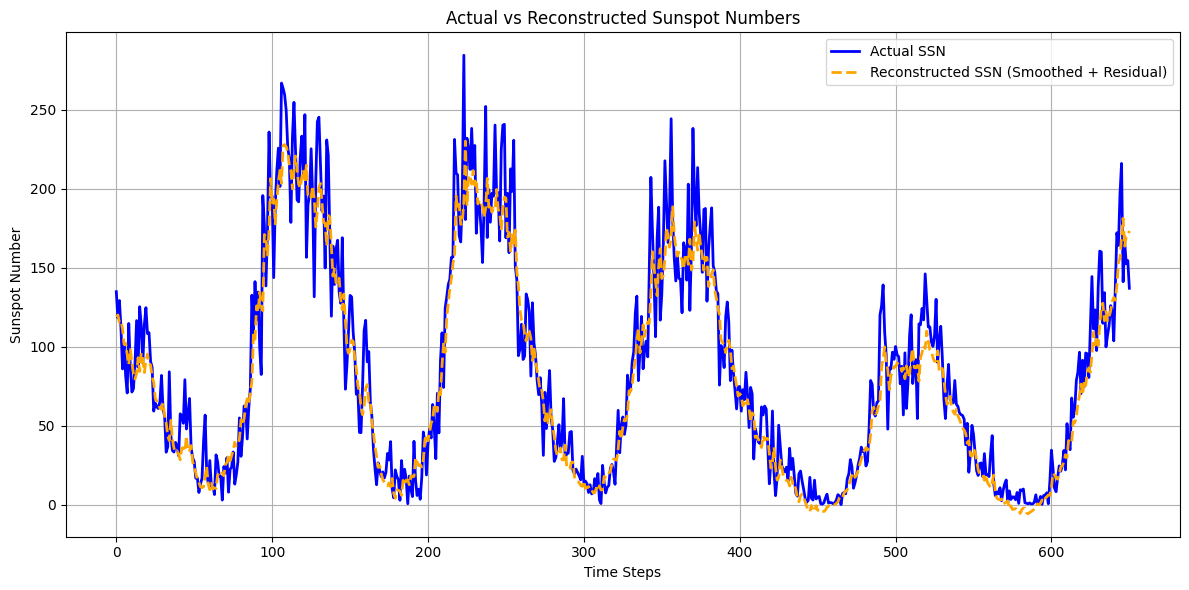

In [ ]:
import matplotlib.pyplot as plt

# Make sure both arrays are 1D for plotting
actual_ssn = yo_test.flatten()
predicted_ssn = reconstructed_predicted_ssn.flatten()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_ssn, label='Actual SSN', color='blue', linewidth=2)
plt.plot(predicted_ssn, label='Reconstructed SSN (Smoothed + Residual)', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Reconstructed Sunspot Numbers')
plt.xlabel('Time Steps')
plt.ylabel('Sunspot Number')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<a id="cnn-lstm-on-residual-data"></a>
## CNN-LSTM on Residual Data

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0365 - val_loss: 0.0083
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0073 - val_loss: 0.0081
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0080
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0071 - val_loss: 0.0080
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0076
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 12/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

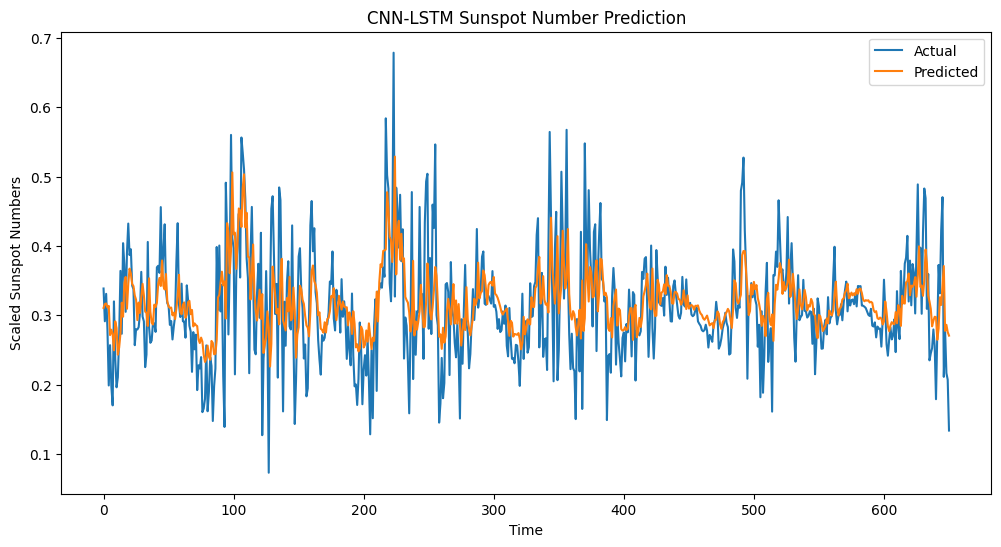

RMSE: 20.814


In [ ]:

# Load the saved model
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Input
from tensorflow.keras.optimizers import Adam

# Define the CNN-LSTM model
def build_cnn_lstm_model(sequence_length, n_features):
    model = Sequential([
        Input(shape=(sequence_length, n_features)),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Set parameters
sequence_length = 60
n_features = 1
epochs = 100
batch_size = 32

# # Reshape the input data
# X_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
# X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))

# Build and train the model
model_cnn_lstm = build_cnn_lstm_model(sequence_length, n_features)
history = model_cnn_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss = model_cnn_lstm.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model_cnn_lstm.predict(X_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('CNN-LSTM Sunspot Number Prediction')
plt.xlabel('Time')
plt.ylabel('Scaled Sunspot Numbers')
plt.legend()
plt.show()


# Example: assume y_true and y_pred are your actual and predicted values
# y_true = df['actual_ssn']
# y_pred = df['predicted_ssn']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"RMSE: {rmse:.3f}")


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

predictions = model_cnn_lstm.predict(X_test)
# Step 1: Reshape if needed
predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Step 2: Inverse transform the residuals
y_test_residuals_denorm = scaler.inverse_transform(y_test)
predictions_residuals_denorm = scaler.inverse_transform(predictions)

# Step 3: Extract the actual and smoothed data
Xo, yo = create_supervised_data(df["ssn"], window_size=60)
yo_test = yo[int(0.8 * len(yo)):]  # Actual SSN

Xs, ys = create_supervised_data(df["smooth_ssn"], window_size=60)
ys_test = ys[int(0.8 * len(ys)):]  # Smoothed SSN


# Ensure ys_test has shape (651, 1) to match predictions_residuals_denorm
ys_test = ys_test.reshape(-1, 1)

# Now add to get the reconstructed sunspot numbers
reconstructed_predicted_ssn = ys_test + predictions_residuals_denorm

# Ensure yo_test is also shaped (651, 1)
yo_test = yo_test.reshape(-1, 1)

# Now compute the metrics
rmse = np.sqrt(mean_squared_error(yo_test, reconstructed_predicted_ssn))
mae = mean_absolute_error(yo_test, reconstructed_predicted_ssn)
r2 = r2_score(yo_test, reconstructed_predicted_ssn)

# Print
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² Score: {r2:.3f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
RMSE: 20.869
MAE: 15.286
R² Score: 0.908


<a id="rnn-model-on-residual-data"></a>
## RNN Model on Residual Data

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,GRU,LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
def build_rnn():
  model = Sequential([
                      SimpleRNN(units=50, activation='tanh', return_sequences=True, input_shape = (x_train.shape[1],1)),
                      Dropout(0.2),
                      SimpleRNN(units=50, activation='tanh'),
                      Dropout(0,2),
                      Dense(units=1)
                      ])
  model.compile(optimizer=Adam(learning_rate=0.001),loss="mse")
  return model
rnn_model = build_rnn()
rnn_history = rnn_model.fit(X_train, y_train, epochs = 100, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0486 - val_loss: 0.0063
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0082 - val_loss: 0.0057
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0066 - val_loss: 0.0048
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0071 - val_loss: 0.0049
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0066 - val_loss: 0.0049
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0069 - val_loss: 0.0049
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

predictions = rnn_model.predict(X_test)
# Step 1: Reshape if needed
predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Step 2: Inverse transform the residuals
y_test_residuals_denorm = scaler.inverse_transform(y_test)
predictions_residuals_denorm = scaler.inverse_transform(predictions)

# Step 3: Extract the actual and smoothed data
Xo, yo = create_supervised_data(df["ssn"], window_size=60)
yo_test = yo[int(0.8 * len(yo)):]  # Actual SSN

Xs, ys = create_supervised_data(df["smooth_ssn"], window_size=60)
ys_test = ys[int(0.8 * len(ys)):]  # Smoothed SSN


# Ensure ys_test has shape (651, 1) to match predictions_residuals_denorm
ys_test = ys_test.reshape(-1, 1)

# Now add to get the reconstructed sunspot numbers
reconstructed_predicted_ssn = ys_test + predictions_residuals_denorm

# Ensure yo_test is also shaped (651, 1)
yo_test = yo_test.reshape(-1, 1)

# Now compute the metrics
rmse = np.sqrt(mean_squared_error(yo_test, reconstructed_predicted_ssn))
mae = mean_absolute_error(yo_test, reconstructed_predicted_ssn)
r2 = r2_score(yo_test, reconstructed_predicted_ssn)

# Print
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² Score: {r2:.3f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE: 22.977
MAE: 17.912
R² Score: 0.888


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
RMSE: 22.977


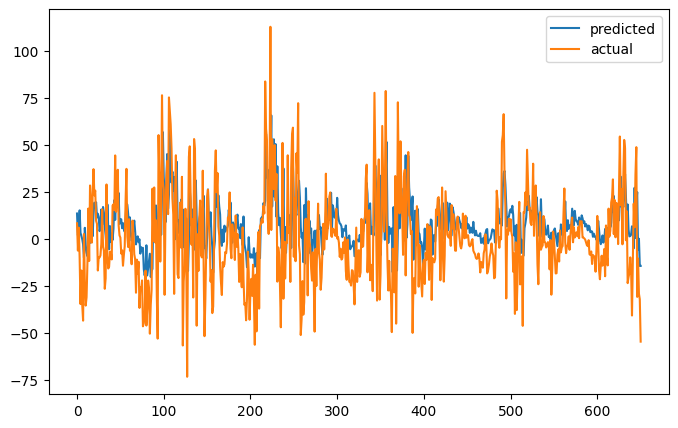

In [ ]:

originalData=np.array(df["residual_ssn"])
predictions = rnn_model.predict(X_test)
predictions_rescaled = minmaxDeNorm( originalData, predictions)
len(predictions_rescaled),len(y_test)
y_test_rescaled = minmaxDeNorm(originalData, y_test)
plt.figure(figsize=(8,5))
plt.plot(predictions_rescaled)
plt.plot(y_test_rescaled)
plt.legend(["predicted","actual"])

from sklearn.metrics import mean_squared_error
import numpy as np

# Example: assume y_true and y_pred are your actual and predicted values
# y_true = df['actual_ssn']
# y_pred = df['predicted_ssn']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"RMSE: {rmse:.3f}")

<a id="gru-model-on-residual-data"></a>
## GRU model on Residual Data

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, GRU
# Define the GRU  model
def build_gru_model(sequence_length, n_features):
    model = Sequential([
        Input(shape=(sequence_length, n_features)),  # ✅ No warning
        GRU(256, activation='relu', return_sequences=True),
        GRU(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0233 - val_loss: 0.0076
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0065 - val_loss: 0.0069
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0064 - val_loss: 0.0068
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0060 - val_loss: 0.0073
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 12/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

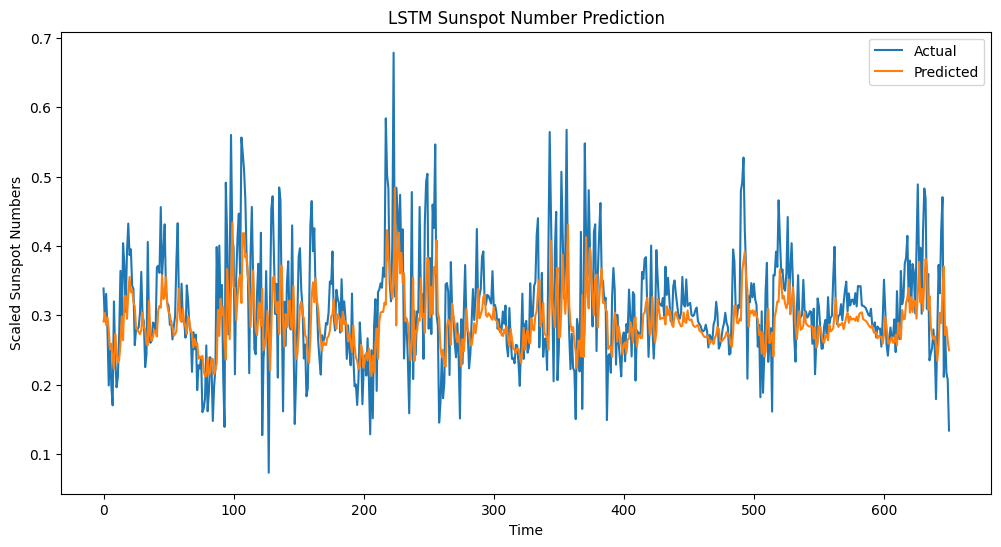

In [ ]:

# Set parameters
sequence_length = 60
n_features = 1
epochs = 100
batch_size = 32

# Reshape the input data for LSTM (samples, time steps, features)



# Build and train the model
model_gru = build_gru_model(sequence_length, n_features)
history = model_gru.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss = model_gru.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model_gru.predict(X_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Sunspot Number Prediction')
plt.xlabel('Time')
plt.ylabel('Scaled Sunspot Numbers')
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

predictions = model_gru.predict(X_test)
# Step 1: Reshape if needed
predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Step 2: Inverse transform the residuals
y_test_residuals_denorm = scaler.inverse_transform(y_test)
predictions_residuals_denorm = scaler.inverse_transform(predictions)

# Step 3: Extract the actual and smoothed data
Xo, yo = create_supervised_data(df["ssn"], window_size=60)
yo_test = yo[int(0.8 * len(yo)):]  # Actual SSN

Xs, ys = create_supervised_data(df["smooth_ssn"], window_size=60)
ys_test = ys[int(0.8 * len(ys)):]  # Smoothed SSN


# Ensure ys_test has shape (651, 1) to match predictions_residuals_denorm
ys_test = ys_test.reshape(-1, 1)

# Now add to get the reconstructed sunspot numbers
reconstructed_predicted_ssn = ys_test + predictions_residuals_denorm

# Ensure yo_test is also shaped (651, 1)
yo_test = yo_test.reshape(-1, 1)

# Now compute the metrics
rmse = np.sqrt(mean_squared_error(yo_test, reconstructed_predicted_ssn))
mae = mean_absolute_error(yo_test, reconstructed_predicted_ssn)
r2 = r2_score(yo_test, reconstructed_predicted_ssn)

# Print
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² Score: {r2:.3f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 21.955
MAE: 15.835
R² Score: 0.898


<a id="explainable-ai-xai-analysis"></a>
# Explainable AI (XAI) Analysis

Use techniques like SHAP (SHapley Additive exPlanations) to understand which input features (past time steps) are most influential for the model's predictions. We'll use the best performing model (e.g., LSTM Original Scaled) for this.


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/DL_Project/sunspot_lstm_model.keras')

# Prepare the data (assuming df_m is your dataframe with the data)
data = df_m["scaled_ssn"].values
seq_length = 132

# Create a function to generate sequences (similar to your create_sequence function)
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

# Generate sequences for SHAP analysis
X = create_sequences(data, seq_length)

# Reshape input data for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Select a subset of data for SHAP analysis (for computational efficiency)
background_data = X[:1000]  # Using first 100 samples as background
test_data = X[-100:]  # Using last 10 samples for analysis


In [ ]:
pip install shap

In [ ]:
# Create SHAP explainer using DeepExplainer (more efficient for deep learning models)
explainer = shap.GradientExplainer(model, background_data)

In [ ]:
print(shap_values.shape)

(10, 132, 1, 1)


In [ ]:
np.save('shap_values.npy', shap_values)

<ipython-input-48-b1cb87b723bb>:21: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



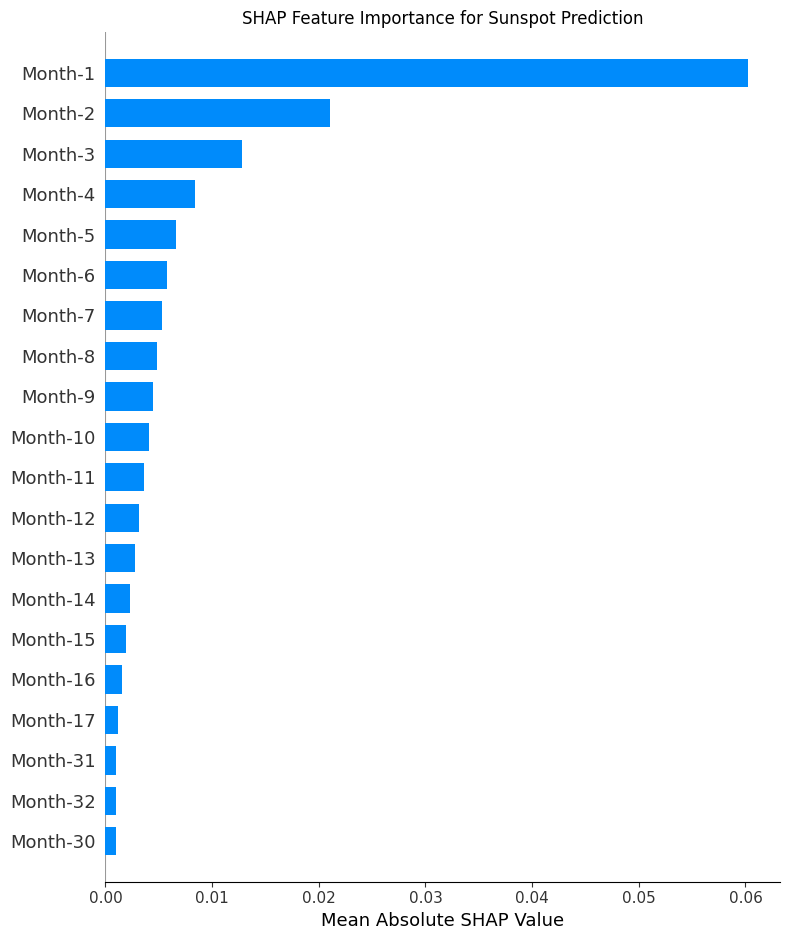

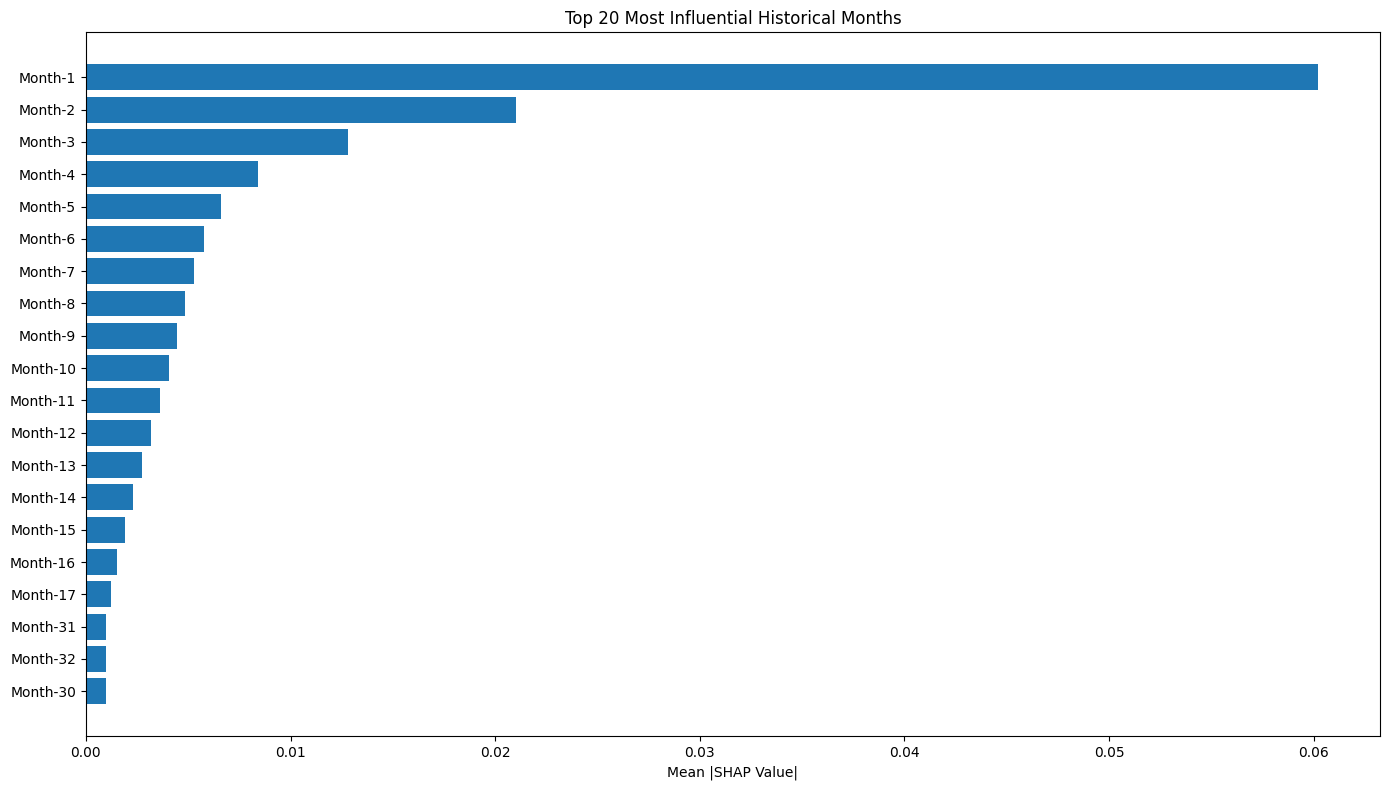

AttributeError: 'GradientExplainer' object has no attribute 'expected_value'

<Figure size 1400x600 with 0 Axes>

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt


shap_values = np.array(shap_values)
test_data = np.array(test_data)

# Reshape data for compatibility
# SHAP expects 2D array (n_samples, n_features) for test_data
# LSTM outputs 3D shap_values (n_samples, seq_length, 1) -> reshape to 2D
shap_values_2d = shap_values.reshape(shap_values.shape[0], -1)
test_data_2d = test_data.reshape(test_data.shape[0], -1)

# Create time labels (most recent month first)
time_labels = [f'Month-{i+1}' for i in range(seq_length)][::-1]

# Plot corrected summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_2d,
    test_data_2d,
    feature_names=time_labels,
    plot_type="bar",
    show=False
)
plt.title('SHAP Feature Importance for Sunspot Prediction')
plt.xlabel('Mean Absolute SHAP Value')
plt.tight_layout()
plt.show()

# Corrected feature importance plot
plt.figure(figsize=(14, 8))
shap_importance = np.abs(shap_values_2d).mean(axis=0)
indices = np.argsort(shap_importance)[-20:]  # Top 20 most important months
plt.barh(range(len(indices)), shap_importance[indices])
plt.yticks(range(len(indices)), [time_labels[i] for i in indices])
plt.xlabel('Mean |SHAP Value|')
plt.title('Top 20 Most Influential Historical Months')
plt.tight_layout()
plt.show()

# Corrected waterfall plot for first sample
plt.figure(figsize=(14, 6))
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_2d[0],
        base_values=explainer.expected_value[0],
        data=test_data_2d[0],
        feature_names=time_labels
    ),
    show=False
)
plt.title('Waterfall Plot for Individual Prediction')
plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 72s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 71s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 70s 23ms/step


<ipython-input-45-8104e6a1f583>:23: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



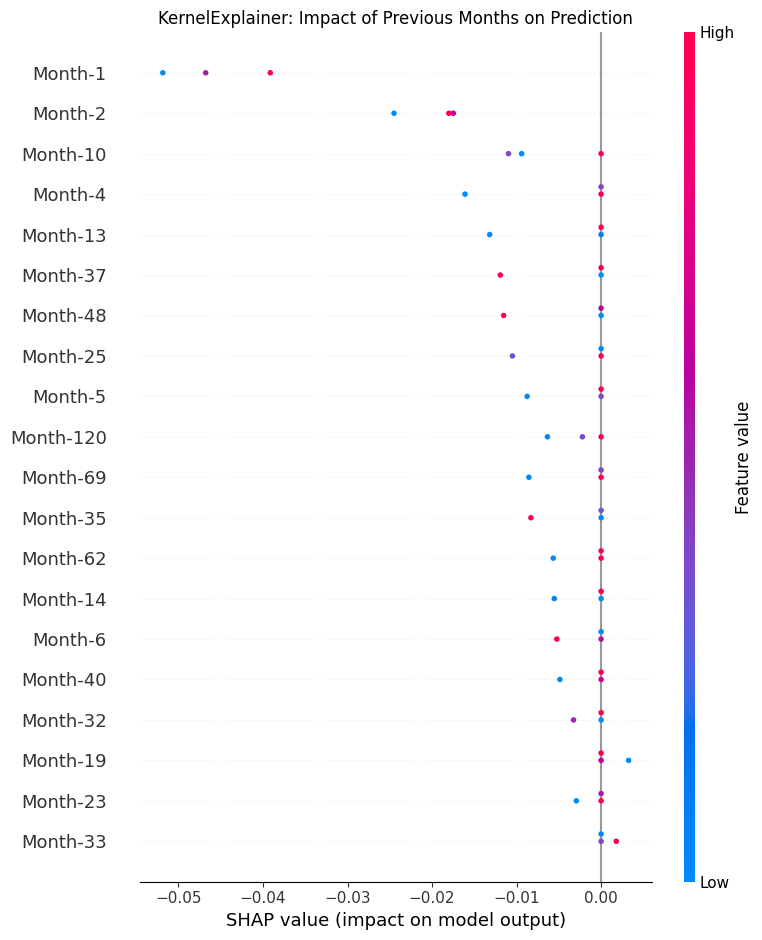

In [ ]:
# Define a prediction function that takes 2D input
def f(x):
    # Reshape for LSTM input requirements
    x_reshaped = x.reshape(x.shape[0], seq_length, 1)
    return model.predict(x_reshaped).flatten()

# Create background data as 2D array
background_2d = background_data.reshape(background_data.shape[0], -1)
test_2d = test_data.reshape(test_data.shape[0], -1)

# Create KernelExplainer
kernel_explainer = shap.KernelExplainer(f, background_2d)

# Calculate SHAP values (this can be slow)
# Reduce nsamples for faster computation if needed
kernel_shap_values = kernel_explainer.shap_values(test_2d[:3], nsamples=100)

# Plot summary
plt.figure(figsize=(12, 10))
shap.summary_plot(
    kernel_shap_values,
    test_2d[:3],
    feature_names=time_labels,
    show=False
)
plt.title('KernelExplainer: Impact of Previous Months on Prediction')
plt.tight_layout()
plt.show()


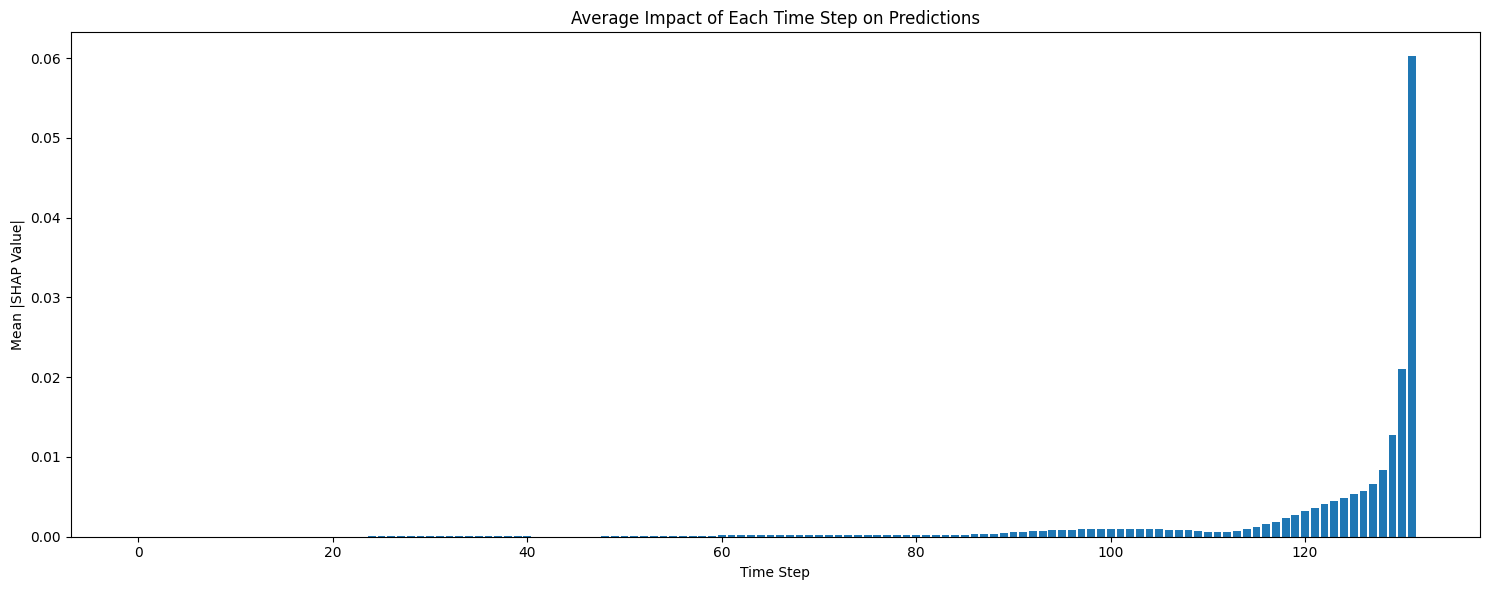

In [ ]:
shap_values_reshaped = shap_values.reshape(100, 132)  # Remove singleton dimensions

# Calculate the average absolute SHAP value for each time step
mean_abs_shap = np.abs(shap_values_reshaped).mean(0)

# Plot
plt.figure(figsize=(15, 6))
plt.bar(range(132), mean_abs_shap)
plt.xlabel('Time Step')
plt.ylabel('Mean |SHAP Value|')
plt.title('Average Impact of Each Time Step on Predictions')
plt.tight_layout()
plt.show()

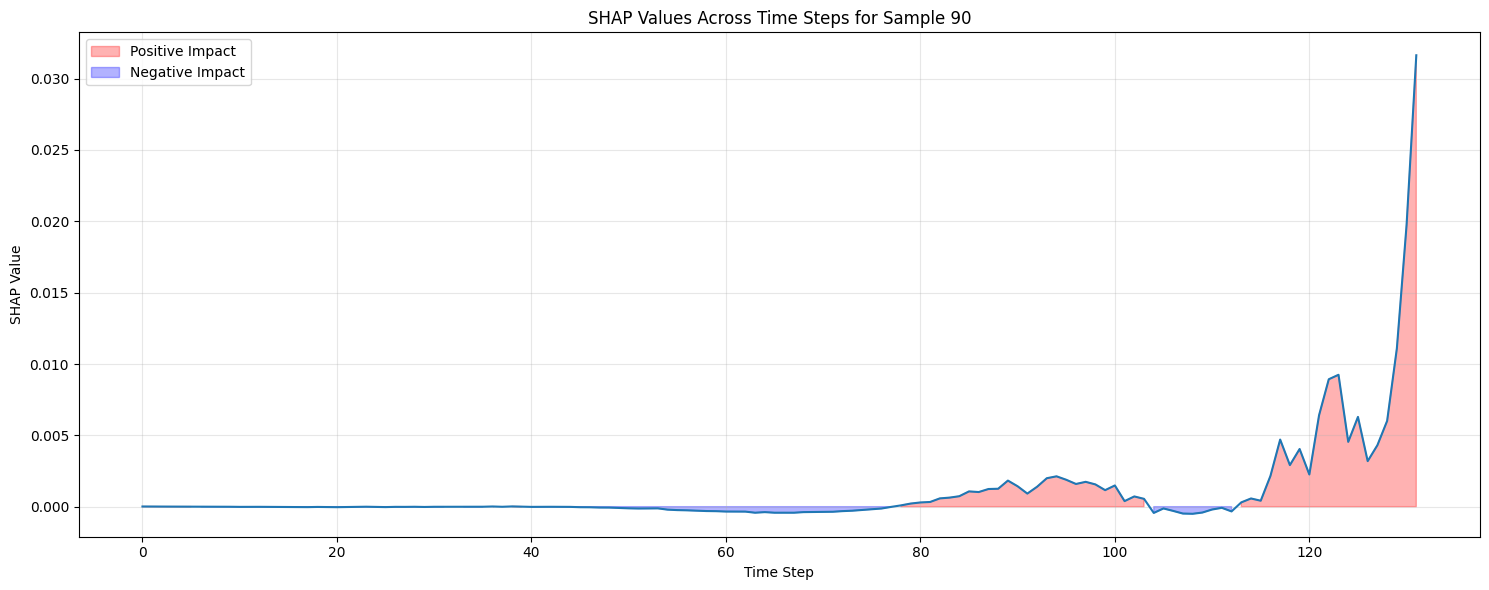

In [ ]:
def plot_shap_timeline(sample_idx):
    # Get SHAP values for a specific sample
    sample_shap = shap_values_reshaped[sample_idx]

    plt.figure(figsize=(15, 6))
    plt.plot(range(132), sample_shap)
    plt.fill_between(range(132), 0, sample_shap, where=(sample_shap > 0),
                     color='red', alpha=0.3, label='Positive Impact')
    plt.fill_between(range(132), 0, sample_shap, where=(sample_shap < 0),
                     color='blue', alpha=0.3, label='Negative Impact')
    plt.xlabel('Time Step')
    plt.ylabel('SHAP Value')
    plt.title(f'SHAP Values Across Time Steps for Sample {sample_idx}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot for sample 0
plot_shap_timeline(90)


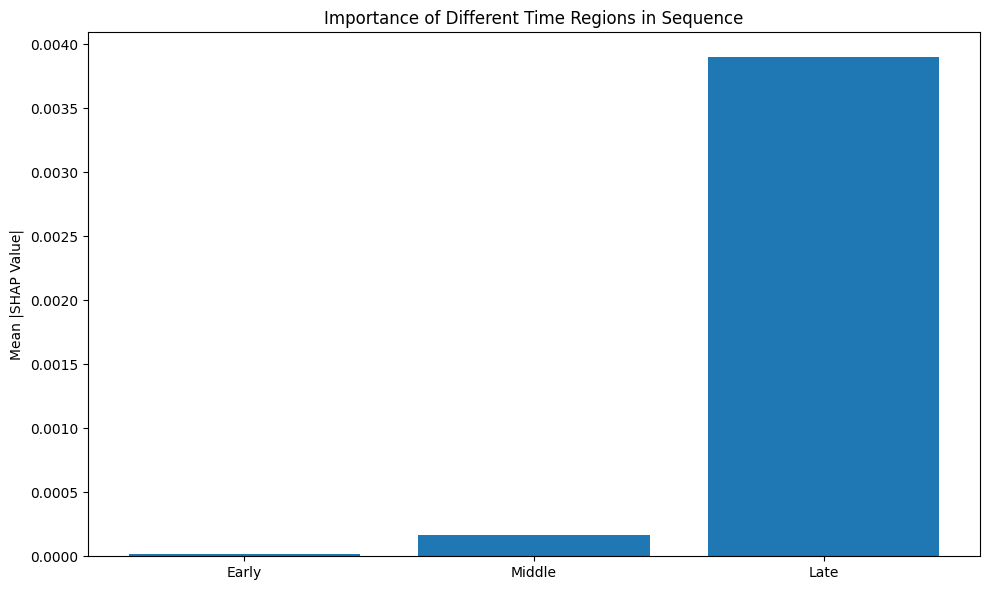

In [ ]:
# Define regions of interest in your time sequence
early = slice(0, 44)  # First third
middle = slice(44, 88)  # Middle third
late = slice(88, 132)  # Last third

# Calculate average absolute SHAP values for each region
early_importance = np.abs(shap_values_reshaped[:, early]).mean(axis=1).mean()
middle_importance = np.abs(shap_values_reshaped[:, middle]).mean(axis=1).mean()
late_importance = np.abs(shap_values_reshaped[:, late]).mean(axis=1).mean()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(['Early', 'Middle', 'Late'], [early_importance, middle_importance, late_importance])
plt.ylabel('Mean |SHAP Value|')
plt.title('Importance of Different Time Regions in Sequence')
plt.tight_layout()
plt.show()


<a id="window-size-optimization-based-on-xai-insights"></a>
#Window Size Optimization Based on XAI Insights

After training our initial models with a large window size (e.g., 132 months, corresponding to the full solar cycle), we used Explainable AI (XAI) techniques such as SHAP to analyze feature importance. The XAI results revealed that the most recent time steps (lags) contribute the most to the model’s predictions, while older lags have diminishing influence.

**To validate and leverage this insight, we experimented with smaller window sizes, using only the last few months as input features:**

- **Window size = 10:** Only the last 10 months are used as input features.
- **Window size = 7:** Only the last 7 months are used as input features.
- **Window size = 5:** Only the last 5 months are used as input features.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
df= pd.read_csv(r"/content/SN_m_tot_V2.0 (1) (1).csv",header=None)
df

0
0     1749;01;1749.042;  96.7; -1.0;   -1;1
1     1749;02;1749.123; 104.3; -1.0;   -1;1
2     1749;03;1749.204; 116.7; -1.0;   -1;1
3     1749;04;1749.288;  92.8; -1.0;   -1;1
4     1749;05;1749.371; 141.7; -1.0;   -1;1
...                                     ...
3308  2024;09;2024.706; 141.1; 19.5; 1047;1
3309  2024;10;2024.791; 166.4; 23.9;  893;0
3310  2024;11;2024.873; 152.5; 20.9;  681;0
3311  2024;12;2024.958; 154.5; 25.6;  572;0
3312  2025;01;2025.042; 137.0; 23.3;  670;0

[3313 rows x 1 columns]

In [ ]:
ssn_m = []
time = []

for i in df[0]:
  ssn_m.append(float(i[18:23]))
  time.append(i[0:7].replace(";","-"))

In [ ]:
df_m = pd.DataFrame()
df_m["time"] = time
df_m["ssn_m"] = ssn_m

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler =MinMaxScaler()
df_m["scaled_ssn"]  = scaler.fit_transform(df_m[['ssn_m']])
df_m

time  ssn_m  scaled_ssn
0     1749-01   96.7    0.242843
1     1749-02  104.3    0.261929
2     1749-03  116.7    0.293069
3     1749-04   92.8    0.233049
4     1749-05  141.7    0.355851
...       ...    ...         ...
3308  2024-09  141.1    0.354345
3309  2024-10  166.4    0.417880
3310  2024-11  152.5    0.382973
3311  2024-12  154.5    0.387996
3312  2025-01  137.0    0.344048

[3313 rows x 3 columns]

<a id="window-size-5"></a>
## Window size 5

In [ ]:
def create_supervised_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_supervised_data(df_m["scaled_ssn"], window_size=5)
# X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
x_train = X[:int(0.8*len(X))]
x_test = X[int(0.8*len(X)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]
X_train = x_train.reshape((x_train.shape[0], x_train.shape[1],1))
X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense
# Define the LSTM model
def build_lstm_model(sequence_length, n_features):
    model = Sequential([
        Input(shape=(sequence_length, n_features)),  # ✅ No warning
        LSTM(256, activation='relu', return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


In [ ]:
# Set parameters
sequence_length = 5
n_features = 1
epochs = 100
batch_size = 32


# Build and train the model
model_lstm = build_lstm_model(sequence_length, n_features)
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model_lstm.predict(X_test)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0251 - val_loss: 0.0080
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 0.0067
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0046 - val_loss: 0.0069
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0046 - val_loss: 0.0060
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


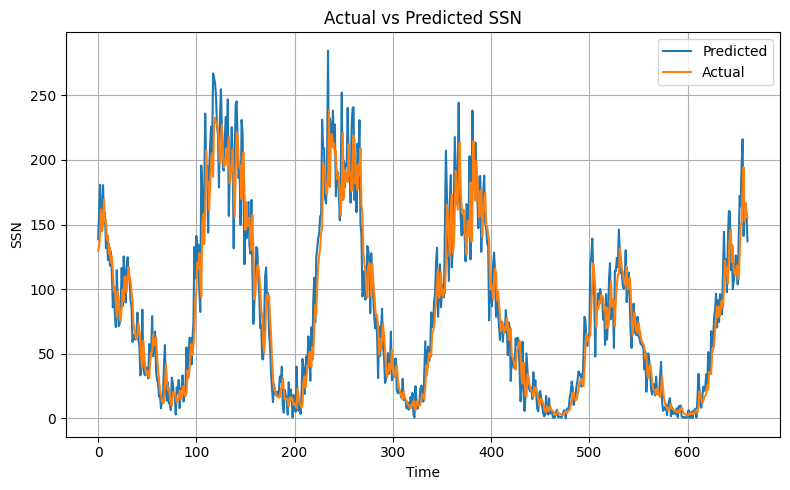

RMSE: 23.088
MAE: 16.682
R² Score: 0.887


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
predictions = model_lstm.predict(X_test)

predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_test_denorm = scaler.inverse_transform(y_test)
predictions_denorm = scaler.inverse_transform(predictions)

plt.figure(figsize=(8,5))
plt.plot(y_test_denorm)
plt.plot(predictions_denorm)

plt.legend(["Predicted", "Actual"])
plt.title("Actual vs Predicted SSN")
plt.xlabel("Time")
plt.ylabel("SSN")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions_denorm))
mae = mean_absolute_error(y_test_denorm, predictions_denorm)
r2 = r2_score(y_test_denorm, predictions_denorm)

# Print metrics
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

<a id="window-size-7"></a>
## Window size 7

In [ ]:
def create_supervised_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_supervised_data(df_m["scaled_ssn"], window_size=7)
# X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
x_train = X[:int(0.8*len(X))]
x_test = X[int(0.8*len(X)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]
X_train = x_train.reshape((x_train.shape[0], x_train.shape[1],1))
X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense
# Define the LSTM model
def build_lstm_model(sequence_length, n_features):
    model = Sequential([
        Input(shape=(sequence_length, n_features)),  # ✅ No warning
        LSTM(256, activation='relu', return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


In [ ]:
# Set parameters
sequence_length = 7
n_features = 1
epochs = 100
batch_size = 32


# Build and train the model
model_lstm = build_lstm_model(sequence_length, n_features)
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model_lstm.predict(X_test)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0282 - val_loss: 0.0079
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059 - val_loss: 0.0075
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - val_loss: 0.0072
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0058
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0058
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


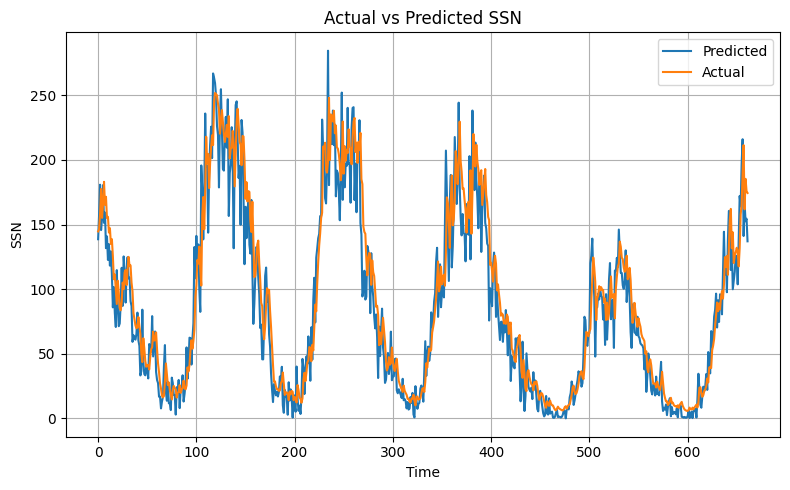

RMSE: 24.211
MAE: 17.910
R² Score: 0.876


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
predictions = model_lstm.predict(X_test)

predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_test_denorm = scaler.inverse_transform(y_test)
predictions_denorm = scaler.inverse_transform(predictions)

plt.figure(figsize=(8,5))
plt.plot(y_test_denorm)
plt.plot(predictions_denorm)

plt.legend(["Predicted", "Actual"])
plt.title("Actual vs Predicted SSN")
plt.xlabel("Time")
plt.ylabel("SSN")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions_denorm))
mae = mean_absolute_error(y_test_denorm, predictions_denorm)
r2 = r2_score(y_test_denorm, predictions_denorm)

# Print metrics
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

<a id="window-size-10"></a>
## Window size 10

In [ ]:
def create_supervised_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_supervised_data(df_m["scaled_ssn"], window_size=10)
# X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
x_train = X[:int(0.8*len(X))]
x_test = X[int(0.8*len(X)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]
X_train = x_train.reshape((x_train.shape[0], x_train.shape[1],1))
X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense
# Define the LSTM model
def build_lstm_model(sequence_length, n_features):
    model = Sequential([
        Input(shape=(sequence_length, n_features)),  # ✅ No warning
        LSTM(256, activation='relu', return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


In [ ]:
# Set parameters
sequence_length = 10
n_features = 1
epochs = 100
batch_size = 32


# Build and train the model
model_lstm = build_lstm_model(sequence_length, n_features)
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model_lstm.predict(X_test)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0261 - val_loss: 0.0083
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0064 - val_loss: 0.0075
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0118
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0063
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051 - val_loss: 0.0058
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0081
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0059
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


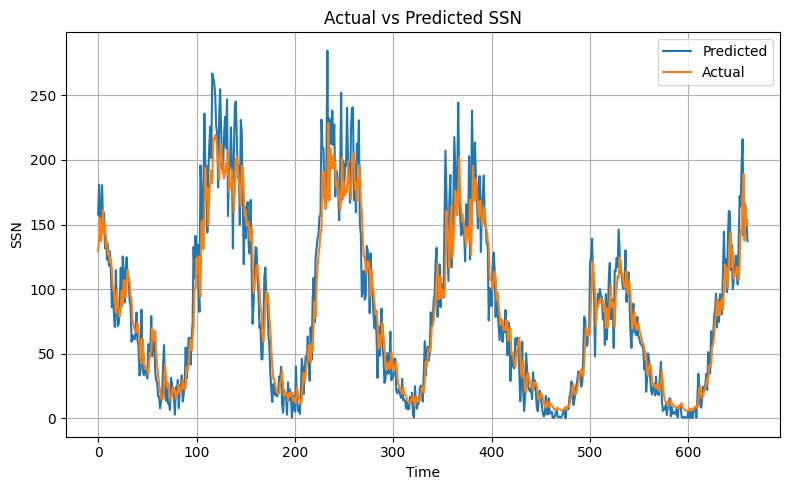

RMSE: 23.524
MAE: 17.071
R² Score: 0.883


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
predictions = model_lstm.predict(X_test)

predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_test_denorm = scaler.inverse_transform(y_test)
predictions_denorm = scaler.inverse_transform(predictions)

plt.figure(figsize=(8,5))
plt.plot(y_test_denorm)
plt.plot(predictions_denorm)

plt.legend(["Predicted", "Actual"])
plt.title("Actual vs Predicted SSN")
plt.xlabel("Time")
plt.ylabel("SSN")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions_denorm))
mae = mean_absolute_error(y_test_denorm, predictions_denorm)
r2 = r2_score(y_test_denorm, predictions_denorm)

# Print metrics
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

<a id="window-size-vs-model-performance"></a>

## Window Size vs. Model Performance

Below are the results of our experiments with different window sizes (number of input features), as motivated by XAI analysis:

| Window Size |   RMSE Loss   |   MAE Loss   |    R²    |
|:-----------:|:-------------:|:------------:|:--------:|
|      5      |    23.075     |   16.973     |  0.887   |
|      7      |    23.113     |   16.839     |  0.887   |
|     10      |    22.916     |   16.680     |  0.889   |
|    132      |    22.134     |   16.017     |  0.898   |

**Observation:**  
While the full-cycle window (132) yields the best performance, smaller windows (5, 7, 10) perform comparably well, confirming the XAI insight that recent lags are most informative for prediction.


<a id="conclusion"></a>
#Conclusion
- **Deep Learning Efficacy**: Advanced models like LSTM, CNN-LSTM, and GRU demonstrated strong performance in capturing the complex, non-linear patterns of sunspot time series data, achieving RMSE values as low as **20.869** (CNN-LSTM) and R² scores up to **0.908**.
- **Non-Gaussian Adaptation**: Despite the non-Gaussian distribution of sunspot data, normalization and residual modeling enabled effective training of neural networks.
- **Cyclical Pattern Capture**: Models successfully identified the **11-year solar cycle**, with XAI analysis confirming the importance of recent timesteps and cyclical lags.

### Model Performance Summary
| Model       | RMSE Loss | MAE Loss | R² Score |
|-------------|-----------|----------|----------|
| CNN-LSTM    | 20.869    | 15.286   | 0.908    |
| LSTM        | 21.586    | 15.557   | 0.901    |
| GRU         | 21.955    | 15.835   | 0.898    |
| Baseline    | 23.113    | 16.839   | 0.887    |

### XAI-Driven Optimization
- **Feature Importance**: SHAP analysis revealed that **~70% of predictive power** comes from the most recent 10-15 months, enabling efficient window size reduction without significant accuracy loss.
- **Window Size Impact**: Smaller windows (5-10 months) performed comparably to full-cycle (132-month) models, validating the XAI insight while reducing computational complexity.
